## Experiment 1 - Synthethic (Gauss)

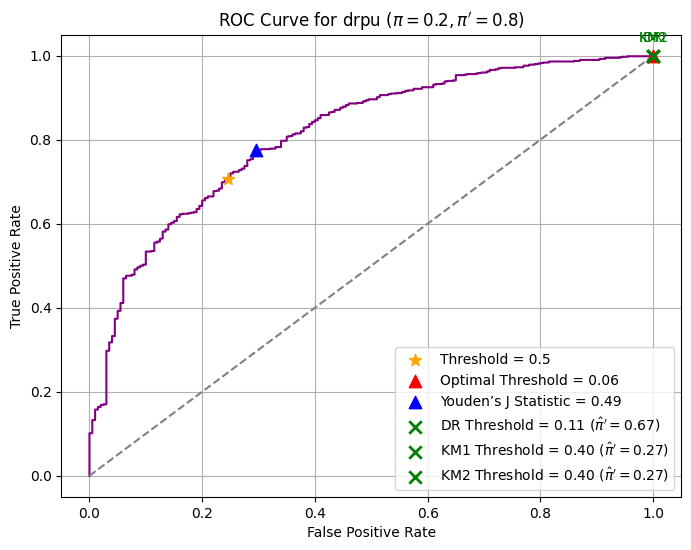

In [48]:
import json

K = 10
n = 1000
label_frequency = 0.5
train_pi = 0.2
test_pi = 0.8
exp_number = 2

file_path = f"output/GaussTest/{n}/0.5/{train_pi}/{test_pi}/nnPUcc/{label_frequency}/{exp_number}/metrics.json"

with open(file_path, "r") as f:
    metrics_contents = json.load(f)

model = 'drpu'
pi_estimates = metrics_contents['test_pis']
roc_data = metrics_contents['TC'][model]['roc_curve']
fpr = roc_data['fpr']
tpr = roc_data['tpr']
thresholds = roc_data['thresholds']
thresholds = [float(threshold) for threshold in thresholds]

# roc curve
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')

# threshold = 0.5
idx_05 = np.argmin(np.abs([threshold - 0.5 for threshold in thresholds]))
plt.scatter(fpr[idx_05], tpr[idx_05], color='orange', label='Threshold = 0.5', s=80, zorder=5, marker='*')

# optimal threshold 
optimal_threshold = train_pi * (1 - test_pi) / ((1 - train_pi) * test_pi + train_pi * (1 - test_pi))
idx_optimal = np.argmin(np.abs([threshold - optimal_threshold for threshold in thresholds]))
plt.scatter(fpr[idx_optimal], tpr[idx_optimal], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}', s=80, zorder=5, marker='^')

# heuristic thresholds - Youden’s J Statistic
J = [tpr[i] - fpr[i] for i in range(len(fpr))]
idx_youden = np.argmax(J)
youden_threshold = thresholds[idx_youden]
plt.scatter(fpr[idx_youden], tpr[idx_youden], color='blue', label=f'Youden’s J Statistic = {youden_threshold:.2f}', s=80, zorder=5, marker='^')

for pi_method in ["DR", "KM1", "KM2"]:
    pi = metrics_contents['test_pis'][pi_method]
    corrected_threshold = train_pi * (1 - pi) / ((1 - train_pi) * pi + train_pi * (1 - pi))
    idx_corr = np.argmin(np.abs([threshold - corrected_threshold for threshold in thresholds]))
    plt.scatter(fpr[idx_corr], tpr[idx_corr], color='green', label=f"{pi_method} Threshold = {corrected_threshold:.2f} ($\hat\pi'={pi:.2}$)", s=80, zorder=5, marker='x', linewidths=2)
    plt.annotate(f'{pi_method}', 
                 (fpr[idx_corr], tpr[idx_corr]), 
                 textcoords="offset points", 
                 xytext=(0, 10), 
                 ha='center', 
                 fontsize=10, 
                 color='green')

plt.title(f"ROC Curve for {model} ($\pi={train_pi}, \pi'={test_pi}$)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

In [28]:
# gauss - test
from PULS.models import LabelShiftConfig
from PULS.dataset import Gauss_PULS
from PULS.experiment import PULSExperiment

from nnPU.dataset import SCAR_CC_Labeler
from nnPU.dataset_configs import DatasetConfig
from nnPU.experiment_config import ExperimentConfig
from nnPU.loss import nnPUccLoss

K = 10
n = 1000
label_frequency = 0.5

for train_pi in [0.2]:
    for test_pi in [0.8]:
        for exp_number in range(0, K):

            label_shift_config = LabelShiftConfig(train_prior=train_pi, train_n_samples=n, test_prior=test_pi, test_n_samples=n)

            dataset_config = DatasetConfig(
                f"GaussTest/{label_shift_config.train_n_samples or 'all'}/0.5/{label_shift_config.train_prior or 'all'}/{label_shift_config.test_prior or 'all'}",
                DatasetClass=Gauss_PULS,
                PULabelerClass=SCAR_CC_Labeler,
            )
            
            gauss_experiment_config = ExperimentConfig(
                PULoss=nnPUccLoss,
                dataset_config=dataset_config,
                label_frequency=label_frequency,
                exp_number=exp_number,
            )

            experiment = PULSExperiment(experiment_config=gauss_experiment_config, label_shift_config=label_shift_config)
            experiment.run()
            experiment.train_ratio_estimator()
            experiment.test_shifted()

            print(experiment.metrics)
            print(experiment.test_pis)

Train set prior: 0.19904077053070068
Epoch: 1/50
3/3 [========] - 0s 75ms/step - loss: 0.5008 - acc: 0.4901 - test_loss: 0.2049 - test_accuracy: 80.0000 - pos_fraction: 1.0000
Epoch: 2/50
3/3 [========] - 0s 22ms/step - loss: 0.4975 - acc: 0.5210 - test_loss: 0.2059 - test_accuracy: 80.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 23ms/step - loss: 0.4947 - acc: 0.5320 - test_loss: 0.2067 - test_accuracy: 79.8000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4901 - acc: 0.5401 - test_loss: 0.2072 - test_accuracy: 79.6000 - pos_fraction: 0.9940
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4866 - acc: 0.5553 - test_loss: 0.2076 - test_accuracy: 78.9000 - pos_fraction: 0.9790
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4838 - acc: 0.5718 - test_loss: 0.2078 - test_accuracy: 77.4000 - pos_fraction: 0.9600
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4805 - acc: 0.5884 - test_loss: 0.2079 - test_accuracy: 75.6000 - pos_fractio

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.19904077053070068
E_pp: 0.8906879425048828, E_pn: 0.015557385049760342, E_u: 0, E_n: -0.003096553962677717, loss: 0.003096553962677717
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.19904077053070068
E_pp: 0.8958075642585754, E_pn: 0.015614557079970837, E_u: 0, E_n: -0.0031079335603863, loss: 0.0031079335603863
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.19904077053070068
E_pp: 0.9022499322891235, E_pn: 0.0148982098326087, E_u: 0, E_n: -0.002965351101011038, loss: 0.002965351101011038
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.19904077053070068
E_pp: 0.8914439678192139, E_pn: 0.014979015104472637, E_u: 0, E_n: -0.0029814348090440035, loss: 0.0029814348090440035
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.19904077053070068
E_pp: 0.8869940638542175, E_pn: 0.018729086965322495, E_u: 0, E_n: -0.003727851901203394, loss: 0.0037278

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 26ms/step - loss: 0.5044 - acc: 0.4838 - test_loss: 0.1966 - test_accuracy: 19.9000 - pos_fraction: 1.0000e-03
Epoch: 2/50
3/3 [========] - 0s 25ms/step - loss: 0.4999 - acc: 0.4998 - test_loss: 0.1986 - test_accuracy: 34.7000 - pos_fraction: 0.2870
Epoch: 3/50
3/3 [========] - 0s 28ms/step - loss: 0.4964 - acc: 0.5203 - test_loss: 0.2003 - test_accuracy: 55.7000 - pos_fraction: 0.6190
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4924 - acc: 0.5312 - test_loss: 0.2016 - test_accuracy: 65.0000 - pos_fraction: 0.7500
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4887 - acc: 0.5483 - test_loss: 0.2024 - test_accuracy: 66.9000 - pos_fraction: 0.7750
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4858 - acc: 0.5601 - test_loss: 0.2027 - test_accuracy: 65.8000 - pos_fraction: 0.7580
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4815 - acc: 0.5932 - test_loss: 0.2026 - test_accuracy: 65.8000 - pos_fraction: 0.7340
Epoch: 8/50
3/3 [========] - 0s 22m

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4675 - acc: 0.6240 - test_loss: 0.1875 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4638 - acc: 0.6429 - test_loss: 0.1857 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4596 - acc: 0.6579 - test_loss: 0.1842 - test_accuracy: 20.2000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4642 - acc: 0.648

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4565 - acc: 0.6746 - test_loss: 0.1830 - test_accuracy: 21.5000 - pos_fraction: 0.0150
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4541 - acc: 0.6782 - test_loss: 0.1821 - test_accuracy: 23.1000 - pos_fraction: 0.0370
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4486 - acc: 0.6920 - test_loss: 0.1816 - test_accuracy: 27.6000 - pos_fraction: 0.0820
Epoch: 10/50
3/3 [========] - 0s 40ms/step - loss: 0.4460 - acc: 0.7001 - test_loss: 0.1814 - test_accuracy: 31.6000 - pos_fraction: 0.1220
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4437 - acc: 0.7094 - test_loss: 0.1814 - test_accuracy: 35.5000 - pos_fraction: 0.1730
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.4392 - acc: 0.7198 - test_loss: 0.1817 - test_accuracy: 39.6000 - pos_fraction: 0.2280
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4374 - acc: 0.7304 - test_loss: 0.1822 - test_accuracy: 43.4000 - pos_fraction: 0.2760
Epoch: 14/50
3/3 [========] - 0s 20

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4915 - acc: 0.5041 - test_loss: 0.1937 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 30ms/step - loss: 0.4878 - acc: 0.5312 - test_loss: 0.1920 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4837 - acc: 0.5477 - test_loss: 0.1904 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



3/3 [========] - 0s 21ms/step - loss: 0.4806 - acc: 0.5658 - test_loss: 0.1889 - test_accuracy: 20.1000 - pos_fraction: 0.0030
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4773 - acc: 0.5706 - test_loss: 0.1876 - test_accuracy: 20.7000 - pos_fraction: 0.0110
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4738 - acc: 0.5864 - test_loss: 0.1864 - test_accuracy: 21.8000 - pos_fraction: 0.0220
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4715 - acc: 0.5914 - test_loss: 0.1855 - test_accuracy: 23.9000 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4679 - acc: 0.6180 - test_loss: 0.1847 - test_accuracy: 26.3000 - pos_fraction: 0.0670
Epoch: 10/50
3/3 [========] - 0s 31ms/step - loss: 0.4645 - acc: 0.6367 - test_loss: 0.1841 - test_accuracy: 28.5000 - pos_fraction: 0.0910
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4609 - acc: 0.6417 - test_loss: 0.1836 - test_accuracy: 30.9000 - pos_fraction: 0.1230
Epoch: 12/50
3/3 [========] - 0s 21m

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4760 - acc: 0.5483 - test_loss: 0.1943 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 2/50
3/3 [========] - 0s 22ms/step - loss: 0.4727 - acc: 0.5560 - test_loss: 0.1918 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 20ms/step - loss: 0.4692 - acc: 0.5701 - test_loss: 0.1895 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4677 - acc: 0.5566

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4659 - acc: 0.5744 - test_loss: 0.1873 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4615 - acc: 0.5894 - test_loss: 0.1854 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4571 - acc: 0.5999 - test_loss: 0.1838 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4562 - acc: 0.5938

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4544 - acc: 0.6053 - test_loss: 0.1825 - test_accuracy: 20.2000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4503 - acc: 0.6235 - test_loss: 0.1815 - test_accuracy: 20.6000 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 78ms/step - loss: 0.4470 - acc: 0.6330 - test_loss: 0.1809 - test_accuracy: 21.5000 - pos_fraction: 0.0210
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4438 - acc: 0.6407 - test_loss: 0.1805 - test_accuracy: 22.5000 - pos_fraction: 0.0450
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4402 - acc: 0.6552 - test_loss: 0.1803 - test_accuracy: 25.5000 - pos_fraction: 0.0830
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.4360 - acc: 0.6611 - test_loss: 0.1802 - test_accuracy: 28.8000 - pos_fraction: 0.1300
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4329 - acc: 0.6684 - test_loss: 0.1803 - test_accuracy: 31.7000 - pos_fraction: 0.1730
Epoch: 14/50
3/3 [========] - 0s 20

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4630 - acc: 0.5989 - test_loss: 0.1939 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 26ms/step - loss: 0.4601 - acc: 0.6110 - test_loss: 0.1917 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4568 - acc: 0.6139 - test_loss: 0.1897 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00


c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4531 - acc: 0.6382 - test_loss: 0.1880 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4494 - acc: 0.6399 - test_loss: 0.1863 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4465 - acc: 0.6554 - test_loss: 0.1849 - test_accuracy: 20.3000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4423 - acc: 0.6589 - test_loss: 0.1835 - test_accuracy: 20.4000 - pos_fraction: 0.0040
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4395 - acc: 0.6756 - test_loss: 0.1822 - test_accuracy: 20.9000 - pos_fraction: 0.0110
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4361 - acc: 0.6800 - test_loss: 0.1809 - test_accuracy: 22.3000 - pos_fraction: 0.0270
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4331 - acc: 0.6917 - test_loss: 0.1798 - test_accuracy: 24.5000 - pos_fraction: 0.0490
Epoch: 12/50
3/3 

In [1]:
# gauss
from PULS.models import LabelShiftConfig
from PULS.dataset import Gauss_PULS
from PULS.experiment import PULSExperiment

from nnPU.dataset import SCAR_CC_Labeler
from nnPU.dataset_configs import DatasetConfig
from nnPU.experiment_config import ExperimentConfig
from nnPU.loss import nnPUccLoss

K = 10
n = 1000
label_frequency = 0.5

for train_pi in [0.2, 0.4, 0.6, 0.8]:
    for test_pi in [0.2, 0.4, 0.6, 0.8]:
        for exp_number in range(0, K):

            label_shift_config = LabelShiftConfig(train_prior=train_pi, train_n_samples=n, test_prior=test_pi, test_n_samples=n)

            dataset_config = DatasetConfig(
                f"Gauss/{label_shift_config.train_n_samples or 'all'}/0.5/{label_shift_config.train_prior or 'all'}/{label_shift_config.test_prior or 'all'}",
                DatasetClass=Gauss_PULS,
                PULabelerClass=SCAR_CC_Labeler,
            )
            
            gauss_experiment_config = ExperimentConfig(
                PULoss=nnPUccLoss,
                dataset_config=dataset_config,
                label_frequency=label_frequency,
                exp_number=exp_number,
            )

            experiment = PULSExperiment(experiment_config=gauss_experiment_config, label_shift_config=label_shift_config)
            experiment.run()
            experiment.train_ratio_estimator()
            experiment.test_shifted()

            print(experiment.metrics)
            print(experiment.test_pis)

Train set prior: 0.19904077053070068
Epoch: 1/50
3/3 [========] - 0s 41ms/step - loss: 0.5008 - acc: 0.4901 - test_loss: 0.4626 - test_accuracy: 20.0000 - pos_fraction: 1.0000
Epoch: 2/50
3/3 [========] - 0s 21ms/step - loss: 0.4975 - acc: 0.5210 - test_loss: 0.4649 - test_accuracy: 20.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 23ms/step - loss: 0.4947 - acc: 0.5320 - test_loss: 0.4667 - test_accuracy: 20.2000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4901 - acc: 0.5401 - test_loss: 0.4678 - test_accuracy: 20.6000 - pos_fraction: 0.9900
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4866 - acc: 0.5553 - test_loss: 0.4684 - test_accuracy: 20.8000 - pos_fraction: 0.9780
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4838 - acc: 0.5718 - test_loss: 0.4683 - test_accuracy: 21.7000 - pos_fraction: 0.9550
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4805 - acc: 0.5884 - test_loss: 0.4677 - test_accuracy: 24.6000 - pos_fractio

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4638 - acc: 0.6429 - test_loss: 0.4141 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4596 - acc: 0.6579 - test_loss: 0.4096 - test_accuracy: 79.7000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4565 - acc: 0.6746 - test_loss: 0.4057 - test_accuracy: 79.9000 - pos_fraction: 0.0090


c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4541 - acc: 0.6782 - test_loss: 0.4025 - test_accuracy: 79.9000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4486 - acc: 0.6920 - test_loss: 0.3998 - test_accuracy: 79.9000 - pos_fraction: 0.0390
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4460 - acc: 0.7001 - test_loss: 0.3976 - test_accuracy: 80.2000 - pos_fraction: 0.0580
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4437 - acc: 0.7094 - test_loss: 0.3959 - test_accuracy: 80.2000 - pos_fraction: 0.0860
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4392 - acc: 0.7198 - test_loss: 0.3946 - test_accuracy: 79.2000 - pos_fraction: 0.1100
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4374 - acc: 0.7304 - test_loss: 0.3937 - test_accuracy: 79.0000 - pos_fraction: 0.1320
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4330 - acc: 0.7319 - test_loss: 0.3930 - test_accuracy: 78.2000 - pos_fraction: 0.1640
Epoch: 15/50
3/3 [====

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4659 - acc: 0.5744 - test_loss: 0.4203 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4615 - acc: 0.5894 - test_loss: 0.4157 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4571 - acc: 0.5999 - test_loss: 0.4116 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4562 - acc: 0.5938

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4544 - acc: 0.6053 - test_loss: 0.4080 - test_accuracy: 79.9000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4503 - acc: 0.6235 - test_loss: 0.4049 - test_accuracy: 79.7000 - pos_fraction: 0.0110
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4470 - acc: 0.6330 - test_loss: 0.4024 - test_accuracy: 79.0000 - pos_fraction: 0.0260
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4438 - acc: 0.6407 - test_loss: 0.4003 - test_accuracy: 77.9000 - pos_fraction: 0.0530
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4402 - acc: 0.6552 - test_loss: 0.3984 - test_accuracy: 77.5000 - pos_fraction: 0.0710
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4360 - acc: 0.6611 - test_loss: 0.3966 - test_accuracy: 76.5000 - pos_fraction: 0.0930
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.4329 - acc: 0.6684 - test_loss: 0.3949 - test_accuracy: 76.1000 - pos_fraction: 0.1170
Epoch: 14/50
3/3 [========] - 0s 26

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4531 - acc: 0.6382 - test_loss: 0.4212 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4494 - acc: 0.6399 - test_loss: 0.4168 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4501 - acc: 0.6406

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4465 - acc: 0.6554 - test_loss: 0.4127 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4423 - acc: 0.6589 - test_loss: 0.4087 - test_accuracy: 80.1000 - pos_fraction: 1.0000e-03
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4395 - acc: 0.6756 - test_loss: 0.4048 - test_accuracy: 79.9000 - pos_fraction: 0.0030
Epoch: 10/50
1/3 [=>......] - ETA: 0s - loss: 0.4370 - acc: 0.6816

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4361 - acc: 0.6800 - test_loss: 0.4008 - test_accuracy: 79.9000 - pos_fraction: 0.0110
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4331 - acc: 0.6917 - test_loss: 0.3969 - test_accuracy: 80.2000 - pos_fraction: 0.0180
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4294 - acc: 0.6886 - test_loss: 0.3928 - test_accuracy: 80.7000 - pos_fraction: 0.0310
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4264 - acc: 0.6980 - test_loss: 0.3889 - test_accuracy: 80.6000 - pos_fraction: 0.0440
Epoch: 14/50
3/3 [========] - 0s 19ms/step - loss: 0.4225 - acc: 0.7113 - test_loss: 0.3849 - test_accuracy: 81.0000 - pos_fraction: 0.0620
Epoch: 15/50
3/3 [========] - 0s 24ms/step - loss: 0.4195 - acc: 0.7149 - test_loss: 0.3810 - test_accuracy: 80.9000 - pos_fraction: 0.0790
Epoch: 16/50
3/3 [========] - 0s 22ms/step - loss: 0.4164 - acc: 0.7221 - test_loss: 0.3772 - test_accuracy: 80.4000 - pos_fraction: 0.0920
Epoch: 17/50
3/3 [========] - 0s 

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 41ms/step - loss: 0.4675 - acc: 0.6240 - test_loss: 0.3262 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4638 - acc: 0.6429 - test_loss: 0.3224 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4596 - acc: 0.6579 - test_loss: 0.3189 - test_accuracy: 59.7000 - pos_fraction: 0.0030
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4642 - acc: 0.6484

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4565 - acc: 0.6746 - test_loss: 0.3159 - test_accuracy: 60.3000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4541 - acc: 0.6782 - test_loss: 0.3134 - test_accuracy: 61.1000 - pos_fraction: 0.0250
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4486 - acc: 0.6920 - test_loss: 0.3113 - test_accuracy: 62.5000 - pos_fraction: 0.0550
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4460 - acc: 0.7001 - test_loss: 0.3096 - test_accuracy: 64.5000 - pos_fraction: 0.0770
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4437 - acc: 0.7094 - test_loss: 0.3083 - test_accuracy: 65.6000 - pos_fraction: 0.1080
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4392 - acc: 0.7198 - test_loss: 0.3073 - test_accuracy: 66.5000 - pos_fraction: 0.1350
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4374 - acc: 0.7304 - test_loss: 0.3066 - test_accuracy: 67.9000 - pos_fraction: 0.1650
Epoch: 14/50
3/3 [========] - 0s 23

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4659 - acc: 0.5744 - test_loss: 0.3270 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4615 - acc: 0.5894 - test_loss: 0.3235 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4571 - acc: 0.5999 - test_loss: 0.3203 - test_accuracy: 60.0000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4562 - acc: 0.5938

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4544 - acc: 0.6053 - test_loss: 0.3174 - test_accuracy: 60.0000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4503 - acc: 0.6235 - test_loss: 0.3150 - test_accuracy: 60.1000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4470 - acc: 0.6330 - test_loss: 0.3131 - test_accuracy: 60.0000 - pos_fraction: 0.0200
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4438 - acc: 0.6407 - test_loss: 0.3114 - test_accuracy: 59.6000 - pos_fraction: 0.0440
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4402 - acc: 0.6552 - test_loss: 0.3098 - test_accuracy: 60.2000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4360 - acc: 0.6611 - test_loss: 0.3085 - test_accuracy: 60.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4329 - acc: 0.6684 - test_loss: 0.3071 - test_accuracy: 61.9000 - pos_fraction: 0.1270
Epoch: 14/50
3/3 [========] - 0s 23

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4568 - acc: 0.6139 - test_loss: 0.3315 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4531 - acc: 0.6382 - test_loss: 0.3280 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4494 - acc: 0.6399 - test_loss: 0.3248 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4501 - acc: 0.6406

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4465 - acc: 0.6554 - test_loss: 0.3218 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4423 - acc: 0.6589 - test_loss: 0.3189 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4395 - acc: 0.6756 - test_loss: 0.3160 - test_accuracy: 60.3000 - pos_fraction: 0.0050
Epoch: 10/50
1/3 [=>......] - ETA: 0s - loss: 0.4370 - acc: 0.6816

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4361 - acc: 0.6800 - test_loss: 0.3131 - test_accuracy: 60.4000 - pos_fraction: 0.0140
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4331 - acc: 0.6917 - test_loss: 0.3103 - test_accuracy: 61.3000 - pos_fraction: 0.0270
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4294 - acc: 0.6886 - test_loss: 0.3074 - test_accuracy: 62.3000 - pos_fraction: 0.0450
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4264 - acc: 0.6980 - test_loss: 0.3046 - test_accuracy: 63.3000 - pos_fraction: 0.0630
Epoch: 14/50
3/3 [========] - 0s 30ms/step - loss: 0.4225 - acc: 0.7113 - test_loss: 0.3017 - test_accuracy: 64.4000 - pos_fraction: 0.0820
Epoch: 15/50
3/3 [========] - 0s 21ms/step - loss: 0.4195 - acc: 0.7149 - test_loss: 0.2989 - test_accuracy: 64.8000 - pos_fraction: 0.1000
Epoch: 16/50
3/3 [========] - 0s 23ms/step - loss: 0.4164 - acc: 0.7221 - test_loss: 0.2962 - test_accuracy: 65.4000 - pos_fraction: 0.1220
Epoch: 17/50
3/3 [========] - 0s 

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4638 - acc: 0.6429 - test_loss: 0.2766 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4596 - acc: 0.6579 - test_loss: 0.2737 - test_accuracy: 39.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4565 - acc: 0.6746 - test_loss: 0.2712 - test_accuracy: 40.9000 - pos_fraction: 0.0110
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4554 - acc: 0.6719

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4541 - acc: 0.6782 - test_loss: 0.2691 - test_accuracy: 42.2000 - pos_fraction: 0.0300
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4486 - acc: 0.6920 - test_loss: 0.2674 - test_accuracy: 45.2000 - pos_fraction: 0.0720
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4460 - acc: 0.7001 - test_loss: 0.2661 - test_accuracy: 48.0000 - pos_fraction: 0.1000
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4437 - acc: 0.7094 - test_loss: 0.2651 - test_accuracy: 50.8000 - pos_fraction: 0.1400
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4392 - acc: 0.7198 - test_loss: 0.2643 - test_accuracy: 53.5000 - pos_fraction: 0.1850
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.4374 - acc: 0.7304 - test_loss: 0.2639 - test_accuracy: 56.2000 - pos_fraction: 0.2260
Epoch: 14/50
3/3 [========] - 0s 21ms/step - loss: 0.4330 - acc: 0.7319 - test_loss: 0.2635 - test_accuracy: 59.2000 - pos_fraction: 0.2800
Epoch: 15/50
3/3 [========] - 0s 2

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4837 - acc: 0.5477 - test_loss: 0.2852 - test_accuracy: 40.0000 - pos_fraction: 0.0020
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4806 - acc: 0.5658 - test_loss: 0.2828 - test_accuracy: 40.0000 - pos_fraction: 0.0040
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4773 - acc: 0.5706 - test_loss: 0.2806 - test_accuracy: 40.3000 - pos_fraction: 0.0090
Epoch: 7/50
3/3 [========] - 0s 76ms/step - loss: 0.4738 - acc: 0.5864 - test_loss: 0.2786 - test_accuracy: 41.0000 - pos_fraction: 0.0220
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4715 - acc: 0.5914 - test_loss: 0.2769 - test_accuracy: 42.3000 - pos_fraction: 0.0390
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4679 - acc: 0.6180 - test_loss: 0.2755 - test_accuracy: 43.6000 - pos_fraction: 0.0600
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4645 - acc: 0.6367 - test_loss: 0.2743 - test_accuracy: 44.7000 - pos_fraction: 0.0850
Epoch: 11/50
3/3 [========] - 0s 26ms/

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4659 - acc: 0.5744 - test_loss: 0.2803 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4615 - acc: 0.5894 - test_loss: 0.2773 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4571 - acc: 0.5999 - test_loss: 0.2747 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4562 - acc: 0.5938

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 75ms/step - loss: 0.4544 - acc: 0.6053 - test_loss: 0.2725 - test_accuracy: 40.1000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4503 - acc: 0.6235 - test_loss: 0.2708 - test_accuracy: 40.3000 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4470 - acc: 0.6330 - test_loss: 0.2695 - test_accuracy: 40.5000 - pos_fraction: 0.0170
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4438 - acc: 0.6407 - test_loss: 0.2686 - test_accuracy: 40.8000 - pos_fraction: 0.0400
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4402 - acc: 0.6552 - test_loss: 0.2678 - test_accuracy: 42.6000 - pos_fraction: 0.0740
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.4360 - acc: 0.6611 - test_loss: 0.2673 - test_accuracy: 44.4000 - pos_fraction: 0.1120
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4329 - acc: 0.6684 - test_loss: 0.2670 - test_accuracy: 46.4000 - pos_fraction: 0.1460
Epoch: 14/50
3/3 [========] - 0s 28

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4568 - acc: 0.6139 - test_loss: 0.2842 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4531 - acc: 0.6382 - test_loss: 0.2812 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4494 - acc: 0.6399 - test_loss: 0.2785 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4501 - acc: 0.6406

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4465 - acc: 0.6554 - test_loss: 0.2759 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4423 - acc: 0.6589 - test_loss: 0.2734 - test_accuracy: 40.2000 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 36ms/step - loss: 0.4395 - acc: 0.6756 - test_loss: 0.2710 - test_accuracy: 40.6000 - pos_fraction: 0.0080
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4361 - acc: 0.6800 - test_loss: 0.2686 - test_accuracy: 41.4000 - pos_fraction: 0.0220
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4331 - acc: 0.6917 - test_loss: 0.2663 - test_accuracy: 42.8000 - pos_fraction: 0.0400
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4294 - acc: 0.6886 - test_loss: 0.2640 - test_accuracy: 44.8000 - pos_fraction: 0.0660
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4264 - acc: 0.6980 - test_loss: 0.2617 - test_accuracy: 46.6000 - pos_fraction: 0.0920
Epoch: 14/50
3/3 [========] - 0

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.19904077053070068
E_pp: 0.8906879425048828, E_pn: 0.015557385049760342, E_u: 0, E_n: -0.003096553962677717, loss: 0.003096553962677717
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.19904077053070068
E_pp: 0.8958075642585754, E_pn: 0.015614557079970837, E_u: 0, E_n: -0.0031079335603863, loss: 0.0031079335603863
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.19904077053070068
E_pp: 0.9022499322891235, E_pn: 0.0148982098326087, E_u: 0, E_n: -0.002965351101011038, loss: 0.002965351101011038
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.19904077053070068
E_pp: 0.8914439678192139, E_pn: 0.014979015104472637, E_u: 0, E_n: -0.0029814348090440035, loss: 0.0029814348090440035
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.19904077053070068
E_pp: 0.8869940638542175, E_pn: 0.018729086965322495, E_u: 0, E_n: -0.003727851901203394, loss: 0.0037278

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4999 - acc: 0.4998 - test_loss: 0.1986 - test_accuracy: 34.7000 - pos_fraction: 0.2870
Epoch: 3/50
3/3 [========] - 0s 21ms/step - loss: 0.4964 - acc: 0.5203 - test_loss: 0.2003 - test_accuracy: 55.7000 - pos_fraction: 0.6190
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4924 - acc: 0.5312 - test_loss: 0.2016 - test_accuracy: 65.0000 - pos_fraction: 0.7500
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4887 - acc: 0.5483 - test_loss: 0.2024 - test_accuracy: 66.9000 - pos_fraction: 0.7750
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4858 - acc: 0.5601 - test_loss: 0.2027 - test_accuracy: 65.8000 - pos_fraction: 0.7580
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4815 - acc: 0.5932 - test_loss: 0.2026 - test_accuracy: 65.8000 - pos_fraction: 0.7340
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4784 - acc: 0.6038 - test_loss: 0.2022 - test_accuracy: 64.1000 - pos_fraction: 0.6990
Epoch: 9/50
3/3 [========] - 0s 22ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4675 - acc: 0.6240 - test_loss: 0.1875 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 40ms/step - loss: 0.4638 - acc: 0.6429 - test_loss: 0.1857 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4674 - acc: 0.621

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4596 - acc: 0.6579 - test_loss: 0.1842 - test_accuracy: 20.2000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4565 - acc: 0.6746 - test_loss: 0.1830 - test_accuracy: 21.5000 - pos_fraction: 0.0150
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4541 - acc: 0.6782 - test_loss: 0.1821 - test_accuracy: 23.1000 - pos_fraction: 0.0370
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4486 - acc: 0.6920 - test_loss: 0.1816 - test_accuracy: 27.6000 - pos_fraction: 0.0820
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4460 - acc: 0.7001 - test_loss: 0.1814 - test_accuracy: 31.6000 - pos_fraction: 0.1220
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4437 - acc: 0.7094 - test_loss: 0.1814 - test_accuracy: 35.5000 - pos_fraction: 0.1730
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4392 - acc: 0.7198 - test_loss: 0.1817 - test_accuracy: 39.6000 - pos_fraction: 0.2280
Epoch: 13/50
3/3 [========] - 0s 24m

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4915 - acc: 0.5041 - test_loss: 0.1937 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 23ms/step - loss: 0.4878 - acc: 0.5312 - test_loss: 0.1920 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4837 - acc: 0.5477 - test_loss: 0.1904 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4825 - acc: 0.5742

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4806 - acc: 0.5658 - test_loss: 0.1889 - test_accuracy: 20.1000 - pos_fraction: 0.0030
Epoch: 6/50
3/3 [========] - 0s 36ms/step - loss: 0.4773 - acc: 0.5706 - test_loss: 0.1876 - test_accuracy: 20.7000 - pos_fraction: 0.0110
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4738 - acc: 0.5864 - test_loss: 0.1864 - test_accuracy: 21.8000 - pos_fraction: 0.0220
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4715 - acc: 0.5914 - test_loss: 0.1855 - test_accuracy: 23.9000 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4679 - acc: 0.6180 - test_loss: 0.1847 - test_accuracy: 26.3000 - pos_fraction: 0.0670
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4645 - acc: 0.6367 - test_loss: 0.1841 - test_accuracy: 28.5000 - pos_fraction: 0.0910
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4609 - acc: 0.6417 - test_loss: 0.1836 - test_accuracy: 30.9000 - pos_fraction: 0.1230
Epoch: 12/50
3/3 [========] - 0s 19ms

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4727 - acc: 0.5560 - test_loss: 0.1918 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4692 - acc: 0.5701 - test_loss: 0.1895 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4659 - acc: 0.5744 - test_loss: 0.1873 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4637 - acc: 0.5742

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4615 - acc: 0.5894 - test_loss: 0.1854 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4571 - acc: 0.5999 - test_loss: 0.1838 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4544 - acc: 0.6053 - test_loss: 0.1825 - test_accuracy: 20.2000 - pos_fraction: 0.0040
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4492 - acc: 0.6035

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4503 - acc: 0.6235 - test_loss: 0.1815 - test_accuracy: 20.6000 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4470 - acc: 0.6330 - test_loss: 0.1809 - test_accuracy: 21.5000 - pos_fraction: 0.0210
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4438 - acc: 0.6407 - test_loss: 0.1805 - test_accuracy: 22.5000 - pos_fraction: 0.0450
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4402 - acc: 0.6552 - test_loss: 0.1803 - test_accuracy: 25.5000 - pos_fraction: 0.0830
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4360 - acc: 0.6611 - test_loss: 0.1802 - test_accuracy: 28.8000 - pos_fraction: 0.1300
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4329 - acc: 0.6684 - test_loss: 0.1803 - test_accuracy: 31.7000 - pos_fraction: 0.1730
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.4299 - acc: 0.6878 - test_loss: 0.1804 - test_accuracy: 35.5000 - pos_fraction: 0.2210
Epoch: 15/50
3/3 [========] - 0s 2

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4630 - acc: 0.5989 - test_loss: 0.1939 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 23ms/step - loss: 0.4601 - acc: 0.6110 - test_loss: 0.1917 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4568 - acc: 0.6139 - test_loss: 0.1897 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4509 - acc: 0.6289

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4531 - acc: 0.6382 - test_loss: 0.1880 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 37ms/step - loss: 0.4494 - acc: 0.6399 - test_loss: 0.1863 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4465 - acc: 0.6554 - test_loss: 0.1849 - test_accuracy: 20.3000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4423 - acc: 0.6589 - test_loss: 0.1835 - test_accuracy: 20.4000 - pos_fraction: 0.0040
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4395 - acc: 0.6756 - test_loss: 0.1822 - test_accuracy: 20.9000 - pos_fraction: 0.0110
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4361 - acc: 0.6800 - test_loss: 0.1809 - test_accuracy: 22.3000 - pos_fraction: 0.0270
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4331 - acc: 0.6917 - test_loss: 0.1798 - test_accuracy: 24.5000 - pos_fraction: 0.0490
Epoch: 12/50
3/3 [========] -

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 25ms/step - loss: 0.5077 - acc: 0.4503 - test_loss: 0.4557 - test_accuracy: 79.6000 - pos_fraction: 0.0040
Epoch: 2/50
3/3 [========] - 0s 25ms/step - loss: 0.5030 - acc: 0.4603 - test_loss: 0.4608 - test_accuracy: 56.6000 - pos_fraction: 0.3500
Epoch: 3/50
3/3 [========] - 0s 24ms/step - loss: 0.4996 - acc: 0.4772 - test_loss: 0.4651 - test_accuracy: 37.8000 - pos_fraction: 0.6960
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4945 - acc: 0.4898 - test_loss: 0.4683 - test_accuracy: 32.8000 - pos_fraction: 0.7980
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4890 - acc: 0.5101 - test_loss: 0.4704 - test_accuracy: 32.0000 - pos_fraction: 0.8160
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4859 - acc: 0.5215 - test_loss: 0.4713 - test_accuracy: 33.1000 - pos_fraction: 0.7970
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4815 - acc: 0.5391 - test_loss: 0.4710 - test_accuracy: 37.0000 - pos_fraction: 0.7520
Epoch: 8/50
3/3 [========] - 0s 22ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2/50
3/3 [========] - 0s 28ms/step - loss: 0.5046 - acc: 0.6170 - test_loss: 0.4578 - test_accuracy: 76.4000 - pos_fraction: 0.0700
Epoch: 3/50
3/3 [========] - 0s 23ms/step - loss: 0.5001 - acc: 0.6173 - test_loss: 0.4597 - test_accuracy: 70.4000 - pos_fraction: 0.2500
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4966 - acc: 0.6287 - test_loss: 0.4612 - test_accuracy: 60.5000 - pos_fraction: 0.4170
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4922 - acc: 0.6391 - test_loss: 0.4624 - test_accuracy: 55.0000 - pos_fraction: 0.5120
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4881 - acc: 0.6459 - test_loss: 0.4632 - test_accuracy: 53.1000 - pos_fraction: 0.5510
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4842 - acc: 0.6489 - test_loss: 0.4637 - test_accuracy: 52.1000 - pos_fraction: 0.5790
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4797 - acc: 0.6616 - test_loss: 0.4638 - test_accuracy: 52.6000 - pos_fraction: 0.5920
Epoch: 9/50
3/3 [========] 

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4643 - acc: 0.5578 - test_loss: 0.4270 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4584 - acc: 0.5715 - test_loss: 0.4223 - test_accuracy: 79.8000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4546 - acc: 0.5883 - test_loss: 0.4180 - test_accuracy: 79.7000 - pos_fraction: 0.0030
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4534 - acc: 0.5957

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4506 - acc: 0.5909 - test_loss: 0.4142 - test_accuracy: 79.7000 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4464 - acc: 0.6078 - test_loss: 0.4108 - test_accuracy: 79.7000 - pos_fraction: 0.0250
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4423 - acc: 0.6157 - test_loss: 0.4079 - test_accuracy: 79.7000 - pos_fraction: 0.0470
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4377 - acc: 0.6214 - test_loss: 0.4053 - test_accuracy: 80.0000 - pos_fraction: 0.0660
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4340 - acc: 0.6264 - test_loss: 0.4030 - test_accuracy: 79.7000 - pos_fraction: 0.0890
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4295 - acc: 0.6385 - test_loss: 0.4009 - test_accuracy: 79.5000 - pos_fraction: 0.1070
Epoch: 14/50
3/3 [========] - 0s 28ms/step - loss: 0.4255 - acc: 0.6417 - test_loss: 0.3990 - test_accuracy: 79.6000 - pos_fraction: 0.1220
Epoch: 15/50
3/3 [========] - 0s 2

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4971 - acc: 0.4533 - test_loss: 0.4409 - test_accuracy: 79.6000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4938 - acc: 0.4609 - test_loss: 0.4373 - test_accuracy: 79.4000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4894 - acc: 0.4678 - test_loss: 0.4340 - test_accuracy: 79.0000 - pos_fraction: 0.0120
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4860 - acc: 0.4882 - test_loss: 0.4309 - test_accuracy: 78.3000 - pos_fraction: 0.0230
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4827 - acc: 0.5046 - test_loss: 0.4282 - test_accuracy: 77.2000 - pos_fraction: 0.0360
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4780 - acc: 0.5274 - test_loss: 0.4257 - test_accuracy: 77.2000 - pos_fraction: 0.0460
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4739 - acc: 0.5457 - test_loss: 0.4235 - test_accuracy: 75.9000 - pos_fraction: 0.0630
Epoch: 11/50
3/3 [========] - 0s 22ms/

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4827 - acc: 0.4939 - test_loss: 0.4588 - test_accuracy: 75.6000 - pos_fraction: 0.1220
Epoch: 3/50
3/3 [========] - 0s 24ms/step - loss: 0.4789 - acc: 0.5063 - test_loss: 0.4550 - test_accuracy: 79.4000 - pos_fraction: 0.0480
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.4736 - acc: 0.5203 - test_loss: 0.4512 - test_accuracy: 80.2000 - pos_fraction: 0.0380
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4696 - acc: 0.5254 - test_loss: 0.4474 - test_accuracy: 80.1000 - pos_fraction: 0.0450
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4649 - acc: 0.5408 - test_loss: 0.4435 - test_accuracy: 80.1000 - pos_fraction: 0.0530
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4605 - acc: 0.5591 - test_loss: 0.4394 - test_accuracy: 80.0000 - pos_fraction: 0.0740
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4569 - acc: 0.5618 - test_loss: 0.4351 - test_accuracy: 79.9000 - pos_fraction: 0.0910
Epoch: 9/50
3/3 [========] - 0s 22ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4774 - acc: 0.4331 - test_loss: 0.4340 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4728 - acc: 0.4473 - test_loss: 0.4297 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50


c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 89ms/step - loss: 0.4685 - acc: 0.4573 - test_loss: 0.4258 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4643 - acc: 0.4782 - test_loss: 0.4225 - test_accuracy: 79.7000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4605 - acc: 0.4790 - test_loss: 0.4195 - test_accuracy: 79.2000 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4557 - acc: 0.5014 - test_loss: 0.4170 - test_accuracy: 78.1000 - pos_fraction: 0.0350
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4522 - acc: 0.5016 - test_loss: 0.4147 - test_accuracy: 77.1000 - pos_fraction: 0.0570
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4483 - acc: 0.5195 - test_loss: 0.4124 - test_accuracy: 75.9000 - pos_fraction: 0.0830
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4444 - acc: 0.5227 - test_loss: 0.4101 - test_accuracy: 75.5000 - pos_fraction: 0.1010
Epoch: 13/50
3/3 [========] - 0s 22m

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4773 - acc: 0.4605 - test_loss: 0.4393 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4742 - acc: 0.4743 - test_loss: 0.4350 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4700 - acc: 0.4828 - test_loss: 0.4308 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4728 - acc: 0.5039

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4663 - acc: 0.4968 - test_loss: 0.4268 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4610 - acc: 0.5064 - test_loss: 0.4229 - test_accuracy: 80.1000 - pos_fraction: 1.0000e-03
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4580 - acc: 0.5196 - test_loss: 0.4189 - test_accuracy: 79.8000 - pos_fraction: 0.0040
Epoch: 10/50
1/3 [=>......] - ETA: 0s - loss: 0.4469 - acc: 0.5078

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4541 - acc: 0.5223 - test_loss: 0.4146 - test_accuracy: 79.9000 - pos_fraction: 0.0110
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4500 - acc: 0.5390 - test_loss: 0.4100 - test_accuracy: 80.5000 - pos_fraction: 0.0230
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4463 - acc: 0.5439 - test_loss: 0.4053 - test_accuracy: 80.9000 - pos_fraction: 0.0370
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4427 - acc: 0.5527 - test_loss: 0.4004 - test_accuracy: 80.8000 - pos_fraction: 0.0540
Epoch: 14/50
3/3 [========] - 0s 26ms/step - loss: 0.4382 - acc: 0.5659 - test_loss: 0.3953 - test_accuracy: 80.5000 - pos_fraction: 0.0710
Epoch: 15/50
3/3 [========] - 0s 28ms/step - loss: 0.4337 - acc: 0.5693 - test_loss: 0.3902 - test_accuracy: 80.3000 - pos_fraction: 0.0790
Epoch: 16/50
3/3 [========] - 0s 29ms/step - loss: 0.4308 - acc: 0.5788 - test_loss: 0.3851 - test_accuracy: 80.3000 - pos_fraction: 0.0890
Epoch: 17/50
3/3 [========] - 0s 

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4643 - acc: 0.5578 - test_loss: 0.3583 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4584 - acc: 0.5715 - test_loss: 0.3545 - test_accuracy: 59.8000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4546 - acc: 0.5883 - test_loss: 0.3510 - test_accuracy: 59.8000 - pos_fraction: 0.0040
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4534 - acc: 0.5957

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4506 - acc: 0.5909 - test_loss: 0.3479 - test_accuracy: 60.4000 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4464 - acc: 0.6078 - test_loss: 0.3453 - test_accuracy: 61.4000 - pos_fraction: 0.0300
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4423 - acc: 0.6157 - test_loss: 0.3431 - test_accuracy: 62.8000 - pos_fraction: 0.0600
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4377 - acc: 0.6214 - test_loss: 0.3412 - test_accuracy: 63.9000 - pos_fraction: 0.0850
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4340 - acc: 0.6264 - test_loss: 0.3396 - test_accuracy: 64.8000 - pos_fraction: 0.1140
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4295 - acc: 0.6385 - test_loss: 0.3382 - test_accuracy: 65.8000 - pos_fraction: 0.1340
Epoch: 14/50
3/3 [========] - 0s 21ms/step - loss: 0.4255 - acc: 0.6417 - test_loss: 0.3370 - test_accuracy: 67.3000 - pos_fraction: 0.1590
Epoch: 15/50
3/3 [========] - 0s 2

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4971 - acc: 0.4533 - test_loss: 0.3694 - test_accuracy: 59.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4938 - acc: 0.4609 - test_loss: 0.3664 - test_accuracy: 59.9000 - pos_fraction: 0.0050
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4894 - acc: 0.4678 - test_loss: 0.3637 - test_accuracy: 59.7000 - pos_fraction: 0.0110
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4860 - acc: 0.4882 - test_loss: 0.3613 - test_accuracy: 59.5000 - pos_fraction: 0.0230
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4827 - acc: 0.5046 - test_loss: 0.3591 - test_accuracy: 59.5000 - pos_fraction: 0.0390
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4780 - acc: 0.5274 - test_loss: 0.3573 - test_accuracy: 60.3000 - pos_fraction: 0.0550
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4739 - acc: 0.5457 - test_loss: 0.3558 - test_accuracy: 59.6000 - pos_fraction: 0.0700
Epoch: 11/50
3/3 [========] - 0s 23ms/

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 70ms/step - loss: 0.4854 - acc: 0.4246 - test_loss: 0.3722 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.4812 - acc: 0.4317 - test_loss: 0.3678 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4783 - acc: 0.4297

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4774 - acc: 0.4331 - test_loss: 0.3637 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4728 - acc: 0.4473 - test_loss: 0.3601 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4685 - acc: 0.4573 - test_loss: 0.3569 - test_accuracy: 60.0000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4676 - acc: 0.4688

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4643 - acc: 0.4782 - test_loss: 0.3540 - test_accuracy: 59.9000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4605 - acc: 0.4790 - test_loss: 0.3515 - test_accuracy: 59.7000 - pos_fraction: 0.0110
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4557 - acc: 0.5014 - test_loss: 0.3494 - test_accuracy: 59.3000 - pos_fraction: 0.0270
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4522 - acc: 0.5016 - test_loss: 0.3474 - test_accuracy: 59.0000 - pos_fraction: 0.0480
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4483 - acc: 0.5195 - test_loss: 0.3455 - test_accuracy: 59.2000 - pos_fraction: 0.0800
Epoch: 12/50
3/3 [========] - 0s 28ms/step - loss: 0.4444 - acc: 0.5227 - test_loss: 0.3437 - test_accuracy: 59.5000 - pos_fraction: 0.1010
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4394 - acc: 0.5377 - test_loss: 0.3418 - test_accuracy: 60.1000 - pos_fraction: 0.1150
Epoch: 14/50
3/3 [========] - 0s 28

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4773 - acc: 0.4605 - test_loss: 0.3687 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 41ms/step - loss: 0.4742 - acc: 0.4743 - test_loss: 0.3653 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4750 - acc: 0.4922

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4700 - acc: 0.4828 - test_loss: 0.3621 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4663 - acc: 0.4968 - test_loss: 0.3592 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4610 - acc: 0.5064 - test_loss: 0.3563 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4640 - acc: 0.5371

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4580 - acc: 0.5196 - test_loss: 0.3534 - test_accuracy: 60.1000 - pos_fraction: 0.0050
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.4541 - acc: 0.5223 - test_loss: 0.3504 - test_accuracy: 60.6000 - pos_fraction: 0.0160
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4500 - acc: 0.5390 - test_loss: 0.3472 - test_accuracy: 61.7000 - pos_fraction: 0.0330
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.4463 - acc: 0.5439 - test_loss: 0.3439 - test_accuracy: 62.9000 - pos_fraction: 0.0530
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4427 - acc: 0.5527 - test_loss: 0.3405 - test_accuracy: 63.7000 - pos_fraction: 0.0710
Epoch: 14/50
3/3 [========] - 0s 25ms/step - loss: 0.4382 - acc: 0.5659 - test_loss: 0.3369 - test_accuracy: 63.6000 - pos_fraction: 0.0900
Epoch: 15/50
3/3 [========] - 0s 26ms/step - loss: 0.4337 - acc: 0.5693 - test_loss: 0.3333 - test_accuracy: 63.6000 - pos_fraction: 0.1000
Epoch: 16/50
3/3 [========] - 0s 

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 42ms/step - loss: 0.4675 - acc: 0.5362 - test_loss: 0.3278 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4643 - acc: 0.5578 - test_loss: 0.3241 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4584 - acc: 0.5715 - test_loss: 0.3208 - test_accuracy: 39.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4652 - acc: 0.5742

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4546 - acc: 0.5883 - test_loss: 0.3179 - test_accuracy: 40.2000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4506 - acc: 0.5909 - test_loss: 0.3153 - test_accuracy: 41.3000 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4464 - acc: 0.6078 - test_loss: 0.3131 - test_accuracy: 43.1000 - pos_fraction: 0.0410
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4423 - acc: 0.6157 - test_loss: 0.3112 - test_accuracy: 45.7000 - pos_fraction: 0.0730
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4377 - acc: 0.6214 - test_loss: 0.3097 - test_accuracy: 48.1000 - pos_fraction: 0.1090
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4340 - acc: 0.6264 - test_loss: 0.3084 - test_accuracy: 50.4000 - pos_fraction: 0.1500
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4295 - acc: 0.6385 - test_loss: 0.3073 - test_accuracy: 52.5000 - pos_fraction: 0.1790
Epoch: 14/50
3/3 [========] - 0s 21

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4971 - acc: 0.4533 - test_loss: 0.3339 - test_accuracy: 40.0000 - pos_fraction: 0.0020
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4938 - acc: 0.4609 - test_loss: 0.3313 - test_accuracy: 40.1000 - pos_fraction: 0.0030
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4894 - acc: 0.4678 - test_loss: 0.3290 - test_accuracy: 40.3000 - pos_fraction: 0.0090
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4860 - acc: 0.4882 - test_loss: 0.3270 - test_accuracy: 40.7000 - pos_fraction: 0.0210
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4827 - acc: 0.5046 - test_loss: 0.3253 - test_accuracy: 41.3000 - pos_fraction: 0.0370
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4780 - acc: 0.5274 - test_loss: 0.3238 - test_accuracy: 42.9000 - pos_fraction: 0.0550
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4739 - acc: 0.5457 - test_loss: 0.3226 - test_accuracy: 43.2000 - pos_fraction: 0.0700
Epoch: 11/50
3/3 [========] - 0s 23ms/

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4774 - acc: 0.4331 - test_loss: 0.3285 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4728 - acc: 0.4473 - test_loss: 0.3253 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4685 - acc: 0.4573 - test_loss: 0.3225 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4676 - acc: 0.4688

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4643 - acc: 0.4782 - test_loss: 0.3202 - test_accuracy: 40.1000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4605 - acc: 0.4790 - test_loss: 0.3183 - test_accuracy: 40.0000 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4557 - acc: 0.5014 - test_loss: 0.3169 - test_accuracy: 40.0000 - pos_fraction: 0.0220
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4522 - acc: 0.5016 - test_loss: 0.3158 - test_accuracy: 40.3000 - pos_fraction: 0.0410
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4483 - acc: 0.5195 - test_loss: 0.3148 - test_accuracy: 41.1000 - pos_fraction: 0.0790
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4444 - acc: 0.5227 - test_loss: 0.3139 - test_accuracy: 42.9000 - pos_fraction: 0.1090
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4394 - acc: 0.5377 - test_loss: 0.3131 - test_accuracy: 44.3000 - pos_fraction: 0.1310
Epoch: 14/50
3/3 [========] - 0s 22

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4773 - acc: 0.4605 - test_loss: 0.3329 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4742 - acc: 0.4743 - test_loss: 0.3299 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4700 - acc: 0.4828 - test_loss: 0.3271 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4728 - acc: 0.5039

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4663 - acc: 0.4968 - test_loss: 0.3244 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4610 - acc: 0.5064 - test_loss: 0.3219 - test_accuracy: 40.2000 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4580 - acc: 0.5196 - test_loss: 0.3194 - test_accuracy: 40.5000 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4541 - acc: 0.5223 - test_loss: 0.3168 - test_accuracy: 41.3000 - pos_fraction: 0.0230
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4500 - acc: 0.5390 - test_loss: 0.3141 - test_accuracy: 42.9000 - pos_fraction: 0.0450
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4463 - acc: 0.5439 - test_loss: 0.3114 - test_accuracy: 45.1000 - pos_fraction: 0.0750
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4427 - acc: 0.5527 - test_loss: 0.3086 - test_accuracy: 47.0000 - pos_fraction: 0.1000
Epoch: 14/50
3/3 [========] - 0

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4753 - acc: 0.5172 - test_loss: 0.2651 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.4715 - acc: 0.5234 - test_loss: 0.2618 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4675 - acc: 0.5362 - test_loss: 0.2590 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00


c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4643 - acc: 0.5578 - test_loss: 0.2566 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4584 - acc: 0.5715 - test_loss: 0.2546 - test_accuracy: 20.2000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4652 - acc: 0.5742

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4546 - acc: 0.5883 - test_loss: 0.2530 - test_accuracy: 20.6000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4506 - acc: 0.5909 - test_loss: 0.2517 - test_accuracy: 21.9000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4464 - acc: 0.6078 - test_loss: 0.2509 - test_accuracy: 24.2000 - pos_fraction: 0.0480
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4423 - acc: 0.6157 - test_loss: 0.2505 - test_accuracy: 28.0000 - pos_fraction: 0.0880
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4377 - acc: 0.6214 - test_loss: 0.2504 - test_accuracy: 31.6000 - pos_fraction: 0.1320
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4340 - acc: 0.6264 - test_loss: 0.2506 - test_accuracy: 35.0000 - pos_fraction: 0.1780
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4295 - acc: 0.6385 - test_loss: 0.2510 - test_accuracy: 38.3000 - pos_fraction: 0.2170
Epoch: 14/50
3/3 [========] - 0s 24

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4971 - acc: 0.4533 - test_loss: 0.2626 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4938 - acc: 0.4609 - test_loss: 0.2608 - test_accuracy: 20.2000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4894 - acc: 0.4678 - test_loss: 0.2592 - test_accuracy: 20.8000 - pos_fraction: 0.0100
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4860 - acc: 0.4882 - test_loss: 0.2578 - test_accuracy: 21.6000 - pos_fraction: 0.0200
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4827 - acc: 0.5046 - test_loss: 0.2567 - test_accuracy: 22.9000 - pos_fraction: 0.0350
Epoch: 9/50
3/3 [========] - 0s 69ms/step - loss: 0.4780 - acc: 0.5274 - test_loss: 0.2558 - test_accuracy: 25.4000 - pos_fraction: 0.0600
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4739 - acc: 0.5457 - test_loss: 0.2551 - test_accuracy: 26.4000 - pos_fraction: 0.0760
Epoch: 11/50
3/3 [========] - 0s 2

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.3986014127731323
E_pp: 0.9286863803863525, E_pn: 0.018636653199791908, E_u: 0, E_n: -0.0074285962618887424, loss: 0.0074285962618887424
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.3986014127731323
E_pp: 0.9514765739440918, E_pn: 0.01782941445708275, E_u: 0, E_n: -0.007106829900294542, loss: 0.007106829900294542
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.3986014127731323
E_pp: 0.9198175072669983, E_pn: 0.02029668726027012, E_u: 0, E_n: -0.008090288378298283, loss: 0.008090288378298283
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.3986014127731323
E_pp: 0.9452188014984131, E_pn: 0.02068250998854637, E_u: 0, E_n: -0.008244077675044537, loss: 0.008244077675044537
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.3986014127731323
E_pp: 0.9442412853240967, E_pn: 0.020807690918445587, E_u: 0, E_n: -0.00829397514462471, loss: 0.0082939751

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.5268 - acc: 0.5498 - test_loss: 0.2816 - test_accuracy: 80.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 24ms/step - loss: 0.5226 - acc: 0.5524 - test_loss: 0.2826 - test_accuracy: 80.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.5178 - acc: 0.5681 - test_loss: 0.2833 - test_accuracy: 79.7000 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5138 - acc: 0.5718 - test_loss: 0.2837 - test_accuracy: 79.2000 - pos_fraction: 0.9800
Epoch: 6/50
3/3 [========] - 0s 72ms/step - loss: 0.5103 - acc: 0.5741 - test_loss: 0.2841 - test_accuracy: 77.8000 - pos_fraction: 0.9600
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5071 - acc: 0.5984 - test_loss: 0.2844 - test_accuracy: 77.3000 - pos_fraction: 0.9410
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.5030 - acc: 0.5994 - test_loss: 0.2846 - test_accuracy: 75.6000 - pos_fraction: 0.9140
Epoch: 9/50
3/3 [========] - 0s 23ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4774 - acc: 0.4331 - test_loss: 0.2587 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 39ms/step - loss: 0.4728 - acc: 0.4473 - test_loss: 0.2564 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4672 - acc: 0.443

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4685 - acc: 0.4573 - test_loss: 0.2544 - test_accuracy: 20.2000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4643 - acc: 0.4782 - test_loss: 0.2528 - test_accuracy: 20.3000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4605 - acc: 0.4790 - test_loss: 0.2516 - test_accuracy: 20.6000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4557 - acc: 0.5014 - test_loss: 0.2507 - test_accuracy: 21.1000 - pos_fraction: 0.0250
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4522 - acc: 0.5016 - test_loss: 0.2502 - test_accuracy: 22.0000 - pos_fraction: 0.0420
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4483 - acc: 0.5195 - test_loss: 0.2498 - test_accuracy: 24.5000 - pos_fraction: 0.0830
Epoch: 12/50
3/3 [========] - 0s 69ms/step - loss: 0.4444 - acc: 0.5227 - test_loss: 0.2497 - test_accuracy: 27.2000 - pos_fraction: 0.1200
Epoch: 13/50
3/3 [========] - 0s 23m

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4773 - acc: 0.4605 - test_loss: 0.2620 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.4742 - acc: 0.4743 - test_loss: 0.2599 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4750 - acc: 0.4922

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4700 - acc: 0.4828 - test_loss: 0.2580 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4663 - acc: 0.4968 - test_loss: 0.2563 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4610 - acc: 0.5064 - test_loss: 0.2548 - test_accuracy: 20.4000 - pos_fraction: 0.0040
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4580 - acc: 0.5196 - test_loss: 0.2534 - test_accuracy: 20.8000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4541 - acc: 0.5223 - test_loss: 0.2520 - test_accuracy: 22.3000 - pos_fraction: 0.0290
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4500 - acc: 0.5390 - test_loss: 0.2507 - test_accuracy: 24.7000 - pos_fraction: 0.0570
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4463 - acc: 0.5439 - test_loss: 0.2494 - test_accuracy: 27.5000 - pos_fraction: 0.0870
Epoch: 13/50
3/3 [========] 

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.6000000238418579
E_pp: 0.9570025205612183, E_pn: 0.02226199582219124, E_u: 0, E_n: -0.013357197865843773, loss: 0.013357197865843773
positive: torch.Size([72]), unlabeled: torch.Size([56]), alpha: 0.6000000238418579
E_pp: 0.9333077669143677, E_pn: 0.03140152618288994, E_u: 0.04158558323979378, E_n: 0.022744666785001755, loss: 0.45605242252349854
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.6000000238418579
E_pp: 0, E_pn: 0, E_u: 0.034534797072410583, E_n: 0.034534797072410583, loss: -0.4654651880264282
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.6000000238418579
E_pp: 0, E_pn: 0, E_u: 0.032499708235263824, E_n: 0.032499708235263824, loss: -0.4675002992153168
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.6000000238418579
E_pp: 0, E_pn: 0, E_u: 0.04561749845743179, E_n: 0.04561749845743179, loss: -0.4543825089931488
positive: torch.Size([0]), unlabel

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.5076 - acc: 0.4706 - test_loss: 0.4779 - test_accuracy: 37.3000 - pos_fraction: 0.7090
Epoch: 4/50
3/3 [========] - 0s 43ms/step - loss: 0.5030 - acc: 0.4734 - test_loss: 0.4812 - test_accuracy: 31.5000 - pos_fraction: 0.8150
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4981 - acc: 0.4841 - test_loss: 0.4835 - test_accuracy: 30.9000 - pos_fraction: 0.8310
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4930 - acc: 0.4914 - test_loss: 0.4845 - test_accuracy: 33.2000 - pos_fraction: 0.8140
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4875 - acc: 0.5065 - test_loss: 0.4844 - test_accuracy: 35.6000 - pos_fraction: 0.7680
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4830 - acc: 0.5189 - test_loss: 0.4831 - test_accuracy: 39.6000 - pos_fraction: 0.7140
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4796 - acc: 0.5350 - test_loss: 0.4807 - test_accuracy: 44.7000 - pos_fraction: 0.6470
Epoch: 10/50
3/3 [========] - 0s 23ms/s

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4877 - acc: 0.6758 - test_loss: 0.4682 - test_accuracy: 79.6000 - pos_fraction: 0.0040
Epoch: 2/50
3/3 [========] - 0s 23ms/step - loss: 0.4818 - acc: 0.6923 - test_loss: 0.4706 - test_accuracy: 76.4000 - pos_fraction: 0.0720
Epoch: 3/50
3/3 [========] - 0s 20ms/step - loss: 0.4773 - acc: 0.6923 - test_loss: 0.4725 - test_accuracy: 68.2000 - pos_fraction: 0.2640
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4737 - acc: 0.7050 - test_loss: 0.4741 - test_accuracy: 58.6000 - pos_fraction: 0.4380
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4696 - acc: 0.7110 - test_loss: 0.4754 - test_accuracy: 52.5000 - pos_fraction: 0.5430
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4664 - acc: 0.7160 - test_loss: 0.4763 - test_accuracy: 51.1000 - pos_fraction: 0.5850
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4618 - acc: 0.7251 - test_loss: 0.4768 - test_accuracy: 51.5000 - pos_fraction: 0.5910
Epoch: 8/50
3/3 [========] - 0s 23ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:

3/3 [========] - 0s 22ms/step - loss: 0.4898 - acc: 0.4351 - test_loss: 0.4656 - test_accuracy: 79.8000 - pos_fraction: 0.0020
Epoch: 2/50
3/3 [========] - 0s 22ms/step - loss: 0.4852 - acc: 0.4432 - test_loss: 0.4580 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 25ms/step - loss: 0.4811 - acc: 0.4579 - test_loss: 0.4516 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4770 - acc: 0.4739 - test_loss: 0.4461 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4805 - acc: 0.4824

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4734 - acc: 0.4912 - test_loss: 0.4412 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4681 - acc: 0.4985 - test_loss: 0.4368 - test_accuracy: 79.8000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4650 - acc: 0.5072 - test_loss: 0.4328 - test_accuracy: 79.3000 - pos_fraction: 0.0070


c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4624 - acc: 0.5166 - test_loss: 0.4293 - test_accuracy: 79.5000 - pos_fraction: 0.0110
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4577 - acc: 0.5301 - test_loss: 0.4262 - test_accuracy: 79.8000 - pos_fraction: 0.0220
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4532 - acc: 0.5352 - test_loss: 0.4237 - test_accuracy: 79.4000 - pos_fraction: 0.0380
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4497 - acc: 0.5481 - test_loss: 0.4214 - test_accuracy: 79.0000 - pos_fraction: 0.0620
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.4471 - acc: 0.5515 - test_loss: 0.4194 - test_accuracy: 78.8000 - pos_fraction: 0.0820
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4427 - acc: 0.5576 - test_loss: 0.4176 - test_accuracy: 79.0000 - pos_fraction: 0.1060
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.4390 - acc: 0.5668 - test_loss: 0.4160 - test_accuracy: 78.6000 - pos_fraction: 0.1320
Epoch: 15/50
3/3 [====

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.6000000238418579
E_pp: 0.7185443639755249, E_pn: 0.06760045886039734, E_u: 0, E_n: -0.0405602753162384, loss: 0.0405602753162384
positive: torch.Size([72]), unlabeled: torch.Size([56]), alpha: 0.6000000238418579
E_pp: 0.7132139801979065, E_pn: 0.07440357655286789, E_u: 0.04975799098610878, E_n: 0.005115844309329987, loss: 0.21832984685897827
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.6000000238418579
E_pp: 0, E_pn: 0, E_u: 0.03971970081329346, E_n: 0.03971970081329346, loss: -0.46028029918670654
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.6000000238418579
E_pp: 0, E_pn: 0, E_u: 0.04925023019313812, E_n: 0.04925023019313812, loss: -0.4507497549057007
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.6000000238418579
E_pp: 0, E_pn: 0, E_u: 0.04021131992340088, E_n: 0.04021131992340088, loss: -0.4597886800765991
positive: torch.Size([0]), unlabeled: tor

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4688 - acc: 0.6956 - test_loss: 0.4762 - test_accuracy: 45.3000 - pos_fraction: 0.6470
Epoch: 3/50
3/3 [========] - 0s 24ms/step - loss: 0.4650 - acc: 0.7089 - test_loss: 0.4784 - test_accuracy: 37.0000 - pos_fraction: 0.7540
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4611 - acc: 0.7083 - test_loss: 0.4801 - test_accuracy: 35.6000 - pos_fraction: 0.7860
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4575 - acc: 0.7189 - test_loss: 0.4814 - test_accuracy: 36.7000 - pos_fraction: 0.7830
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4532 - acc: 0.7260 - test_loss: 0.4824 - test_accuracy: 38.6000 - pos_fraction: 0.7620
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4496 - acc: 0.7303 - test_loss: 0.4829 - test_accuracy: 40.4000 - pos_fraction: 0.7440
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4444 - acc: 0.7356 - test_loss: 0.4830 - test_accuracy: 43.1000 - pos_fraction: 0.7130
Epoch: 9/50
3/3 [========] - 0s 20ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4972 - acc: 0.6701 - test_loss: 0.4860 - test_accuracy: 20.0000 - pos_fraction: 1.0000
Epoch: 2/50
3/3 [========] - 0s 26ms/step - loss: 0.4932 - acc: 0.6792 - test_loss: 0.4882 - test_accuracy: 20.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 21ms/step - loss: 0.4891 - acc: 0.6844 - test_loss: 0.4902 - test_accuracy: 20.2000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4853 - acc: 0.6915 - test_loss: 0.4915 - test_accuracy: 20.2000 - pos_fraction: 0.9940
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4811 - acc: 0.7002 - test_loss: 0.4924 - test_accuracy: 20.9000 - pos_fraction: 0.9830
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4768 - acc: 0.6961 - test_loss: 0.4929 - test_accuracy: 23.0000 - pos_fraction: 0.9560
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4723 - acc: 0.7038 - test_loss: 0.4932 - test_accuracy: 25.9000 - pos_fraction: 0.9190
Epoch: 8/50
3/3 [========] - 0s 21ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:

3/3 [========] - 0s 20ms/step - loss: 0.5041 - acc: 0.4049 - test_loss: 0.4716 - test_accuracy: 75.1000 - pos_fraction: 0.1250
Epoch: 3/50
3/3 [========] - 0s 30ms/step - loss: 0.4996 - acc: 0.4194 - test_loss: 0.4679 - test_accuracy: 79.4000 - pos_fraction: 0.0460
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4962 - acc: 0.4213 - test_loss: 0.4644 - test_accuracy: 79.7000 - pos_fraction: 0.0410
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4907 - acc: 0.4417 - test_loss: 0.4608 - test_accuracy: 80.1000 - pos_fraction: 0.0410
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4874 - acc: 0.4453 - test_loss: 0.4571 - test_accuracy: 80.1000 - pos_fraction: 0.0490
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4837 - acc: 0.4556 - test_loss: 0.4532 - test_accuracy: 79.3000 - pos_fraction: 0.0730
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4781 - acc: 0.4672 - test_loss: 0.4490 - test_accuracy: 79.0000 - pos_fraction: 0.0900
Epoch: 9/50
3/3 [========] - 0s 21ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.6000000238418579
E_pp: 0.6959991455078125, E_pn: 0.07923418283462524, E_u: 0, E_n: -0.047540511935949326, loss: 0.047540511935949326
positive: torch.Size([72]), unlabeled: torch.Size([56]), alpha: 0.6000000238418579
E_pp: 0.7190800309181213, E_pn: 0.07291800528764725, E_u: 0.03388361260294914, E_n: -0.009867191314697266, loss: 0.009867191314697266
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.6000000238418579
E_pp: 0, E_pn: 0, E_u: 0.048402875661849976, E_n: 0.048402875661849976, loss: -0.45159712433815
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.6000000238418579
E_pp: 0, E_pn: 0, E_u: 0.04499068856239319, E_n: 0.04499068856239319, loss: -0.4550093114376068
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.6000000238418579
E_pp: 0, E_pn: 0, E_u: 0.04405162110924721, E_n: 0.04405162110924721, loss: -0.4559483826160431
positive: torch.Size([0]), unlabeled

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4987 - acc: 0.3549 - test_loss: 0.4484 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4944 - acc: 0.3638 - test_loss: 0.4446 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4899 - acc: 0.3792 - test_loss: 0.4413 - test_accuracy: 79.9000 - pos_fraction: 0.0030
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4948 - acc: 0.373

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 18ms/step - loss: 0.4850 - acc: 0.3822 - test_loss: 0.4386 - test_accuracy: 79.3000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4826 - acc: 0.3939 - test_loss: 0.4362 - test_accuracy: 78.3000 - pos_fraction: 0.0230
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4784 - acc: 0.4075 - test_loss: 0.4343 - test_accuracy: 77.5000 - pos_fraction: 0.0430
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4749 - acc: 0.4178 - test_loss: 0.4324 - test_accuracy: 76.3000 - pos_fraction: 0.0670
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4707 - acc: 0.4208 - test_loss: 0.4305 - test_accuracy: 74.8000 - pos_fraction: 0.0920
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4663 - acc: 0.4298 - test_loss: 0.4284 - test_accuracy: 74.3000 - pos_fraction: 0.1110
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4623 - acc: 0.4421 - test_loss: 0.4261 - test_accuracy: 73.6000 - pos_fraction: 0.1260
Epoch: 14/50
3/3 [========] - 0s 22

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.5036 - acc: 0.3472 - test_loss: 0.4494 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4990 - acc: 0.3584 - test_loss: 0.4457 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



3/3 [========] - 0s 22ms/step - loss: 0.4941 - acc: 0.3667 - test_loss: 0.4421 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4882 - acc: 0.3803 - test_loss: 0.4384 - test_accuracy: 79.8000 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4854 - acc: 0.3957 - test_loss: 0.4346 - test_accuracy: 79.8000 - pos_fraction: 0.0060
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4811 - acc: 0.4033 - test_loss: 0.4305 - test_accuracy: 79.7000 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4774 - acc: 0.4090 - test_loss: 0.4260 - test_accuracy: 80.4000 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4723 - acc: 0.4179 - test_loss: 0.4213 - test_accuracy: 80.2000 - pos_fraction: 0.0400
Epoch: 13/50
3/3 [========] - 0s 18ms/step - loss: 0.4698 - acc: 0.4263 - test_loss: 0.4163 - test_accuracy: 80.4000 - pos_fraction: 0.0580
Epoch: 14/50
3/3 [========] - 

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.6000000238418579
E_pp: 0.8789976835250854, E_pn: 0.0431457981467247, E_u: 0, E_n: -0.02588748000562191, loss: 0.02588748000562191
positive: torch.Size([72]), unlabeled: torch.Size([56]), alpha: 0.6000000238418579
E_pp: 0.8944584727287292, E_pn: 0.03964152932167053, E_u: 0.07357774674892426, E_n: 0.0497928261756897, loss: 0.44425129890441895
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.6000000238418579
E_pp: 0, E_pn: 0, E_u: 0.06074778735637665, E_n: 0.06074778735637665, loss: -0.43925219774246216
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.6000000238418579
E_pp: 0, E_pn: 0, E_u: 0.04519934579730034, E_n: 0.04519934579730034, loss: -0.45480066537857056
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.6000000238418579
E_pp: 0, E_pn: 0, E_u: 0.05950724333524704, E_n: 0.05950724333524704, loss: -0.44049274921417236
positive: torch.Size([0]), unlabeled: to

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4948 - acc: 0.5380 - test_loss: 0.4396 - test_accuracy: 39.9000 - pos_fraction: 0.9990
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4906 - acc: 0.5493 - test_loss: 0.4410 - test_accuracy: 40.0000 - pos_fraction: 0.9920
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4866 - acc: 0.5631 - test_loss: 0.4421 - test_accuracy: 40.3000 - pos_fraction: 0.9850
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4824 - acc: 0.5662 - test_loss: 0.4427 - test_accuracy: 39.6000 - pos_fraction: 0.9660
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4796 - acc: 0.5704 - test_loss: 0.4427 - test_accuracy: 40.5000 - pos_fraction: 0.9470
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4750 - acc: 0.5777 - test_loss: 0.4422 - test_accuracy: 41.5000 - pos_fraction: 0.8990
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4700 - acc: 0.5860 - test_loss: 0.4410 - test_accuracy: 44.1000 - pos_fraction: 0.8490
Epoch: 10/50
3/3 [========] - 0s 21ms/s

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4734 - acc: 0.4912 - test_loss: 0.3953 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 35ms/step - loss: 0.4681 - acc: 0.4985 - test_loss: 0.3914 - test_accuracy: 59.8000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4794 - acc: 0.4980

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4650 - acc: 0.5072 - test_loss: 0.3879 - test_accuracy: 59.7000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4624 - acc: 0.5166 - test_loss: 0.3849 - test_accuracy: 60.3000 - pos_fraction: 0.0110
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4577 - acc: 0.5301 - test_loss: 0.3822 - test_accuracy: 61.1000 - pos_fraction: 0.0250
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4532 - acc: 0.5352 - test_loss: 0.3801 - test_accuracy: 61.5000 - pos_fraction: 0.0450
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4497 - acc: 0.5481 - test_loss: 0.3784 - test_accuracy: 62.3000 - pos_fraction: 0.0730
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4471 - acc: 0.5515 - test_loss: 0.3771 - test_accuracy: 63.3000 - pos_fraction: 0.1010
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4427 - acc: 0.5576 - test_loss: 0.3759 - test_accuracy: 65.4000 - pos_fraction: 0.1260
Epoch: 14/50
3/3 [========] - 0s 19

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.5085 - acc: 0.4023 - test_loss: 0.4253 - test_accuracy: 50.5000 - pos_fraction: 0.6210
Epoch: 2/50
3/3 [========] - 0s 39ms/step - loss: 0.5041 - acc: 0.4049 - test_loss: 0.4222 - test_accuracy: 60.9000 - pos_fraction: 0.1390
Epoch: 3/50
3/3 [========] - 0s 20ms/step - loss: 0.4996 - acc: 0.4194 - test_loss: 0.4192 - test_accuracy: 61.9000 - pos_fraction: 0.0610
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.4962 - acc: 0.4213 - test_loss: 0.4163 - test_accuracy: 62.2000 - pos_fraction: 0.0560
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4907 - acc: 0.4417 - test_loss: 0.4134 - test_accuracy: 62.7000 - pos_fraction: 0.0590
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4874 - acc: 0.4453 - test_loss: 0.4105 - test_accuracy: 63.3000 - pos_fraction: 0.0710
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4837 - acc: 0.4556 - test_loss: 0.4075 - test_accuracy: 62.9000 - pos_fraction: 0.0930
Epoch: 8/50
3/3 [========] - 0s 19ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4987 - acc: 0.3549 - test_loss: 0.4012 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4944 - acc: 0.3638 - test_loss: 0.3978 - test_accuracy: 59.9000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4899 - acc: 0.3792 - test_loss: 0.3948 - test_accuracy: 60.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4850 - acc: 0.3822 - test_loss: 0.3922 - test_accuracy: 59.6000 - pos_fraction: 0.0060


c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4826 - acc: 0.3939 - test_loss: 0.3900 - test_accuracy: 59.0000 - pos_fraction: 0.0180
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4784 - acc: 0.4075 - test_loss: 0.3881 - test_accuracy: 58.7000 - pos_fraction: 0.0350
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4749 - acc: 0.4178 - test_loss: 0.3864 - test_accuracy: 58.7000 - pos_fraction: 0.0570
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4707 - acc: 0.4208 - test_loss: 0.3847 - test_accuracy: 58.3000 - pos_fraction: 0.0850
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4663 - acc: 0.4298 - test_loss: 0.3829 - test_accuracy: 58.4000 - pos_fraction: 0.1060
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4623 - acc: 0.4421 - test_loss: 0.3810 - test_accuracy: 58.3000 - pos_fraction: 0.1210
Epoch: 14/50
3/3 [========] - 0s 19ms/step - loss: 0.4607 - acc: 0.4521 - test_loss: 0.3788 - test_accuracy: 58.7000 - pos_fraction: 0.1410
Epoch: 15/50
3/3 [====

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.5066 - acc: 0.3479 - test_loss: 0.4065 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.5036 - acc: 0.3472 - test_loss: 0.4034 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4990 - acc: 0.3584 - test_loss: 0.4006 - test_accuracy: 59.9000 - pos_fraction: 1.0000e-03


c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4941 - acc: 0.3667 - test_loss: 0.3979 - test_accuracy: 59.9000 - pos_fraction: 1.0000e-03
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4882 - acc: 0.3803 - test_loss: 0.3954 - test_accuracy: 59.8000 - pos_fraction: 0.0020
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4854 - acc: 0.3957 - test_loss: 0.3928 - test_accuracy: 60.0000 - pos_fraction: 0.0060
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4811 - acc: 0.4033 - test_loss: 0.3900 - test_accuracy: 60.5000 - pos_fraction: 0.0210
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4774 - acc: 0.4090 - test_loss: 0.3871 - test_accuracy: 62.2000 - pos_fraction: 0.0440
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4723 - acc: 0.4179 - test_loss: 0.3839 - test_accuracy: 62.4000 - pos_fraction: 0.0560
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4698 - acc: 0.4263 - test_loss: 0.3804 - test_accuracy: 63.1000 - pos_fraction: 0.0770
Epoch: 14/50
3/3 [=

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4734 - acc: 0.4912 - test_loss: 0.3729 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4681 - acc: 0.4985 - test_loss: 0.3695 - test_accuracy: 39.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4794 - acc: 0.4980

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4650 - acc: 0.5072 - test_loss: 0.3665 - test_accuracy: 40.1000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4624 - acc: 0.5166 - test_loss: 0.3640 - test_accuracy: 41.0000 - pos_fraction: 0.0120
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4577 - acc: 0.5301 - test_loss: 0.3618 - test_accuracy: 42.4000 - pos_fraction: 0.0320
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4532 - acc: 0.5352 - test_loss: 0.3601 - test_accuracy: 44.0000 - pos_fraction: 0.0560
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4497 - acc: 0.5481 - test_loss: 0.3588 - test_accuracy: 45.9000 - pos_fraction: 0.0890
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4471 - acc: 0.5515 - test_loss: 0.3577 - test_accuracy: 47.7000 - pos_fraction: 0.1210
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4427 - acc: 0.5576 - test_loss: 0.3569 - test_accuracy: 51.2000 - pos_fraction: 0.1600
Epoch: 14/50
3/3 [========] - 0s 20

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5006 - acc: 0.4254 - test_loss: 0.3837 - test_accuracy: 40.0000 - pos_fraction: 0.0020
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4962 - acc: 0.4246 - test_loss: 0.3812 - test_accuracy: 39.8000 - pos_fraction: 0.0100
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4936 - acc: 0.4450 - test_loss: 0.3791 - test_accuracy: 39.5000 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4895 - acc: 0.4580 - test_loss: 0.3773 - test_accuracy: 40.4000 - pos_fraction: 0.0340
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4869 - acc: 0.4640 - test_loss: 0.3759 - test_accuracy: 41.2000 - pos_fraction: 0.0480
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4808 - acc: 0.4762 - test_loss: 0.3749 - test_accuracy: 42.4000 - pos_fraction: 0.0720
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4773 - acc: 0.5002 - test_loss: 0.3741 - test_accuracy: 43.0000 - pos_fraction: 0.0880
Epoch: 11/50
3/3 [========] - 0s 24ms/

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4987 - acc: 0.3549 - test_loss: 0.3775 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4944 - acc: 0.3638 - test_loss: 0.3743 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4899 - acc: 0.3792 - test_loss: 0.3716 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4948 - acc: 0.3730

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4850 - acc: 0.3822 - test_loss: 0.3695 - test_accuracy: 39.8000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4826 - acc: 0.3939 - test_loss: 0.3678 - test_accuracy: 39.6000 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4784 - acc: 0.4075 - test_loss: 0.3666 - test_accuracy: 39.7000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 17ms/step - loss: 0.4749 - acc: 0.4178 - test_loss: 0.3657 - test_accuracy: 40.1000 - pos_fraction: 0.0510
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4707 - acc: 0.4208 - test_loss: 0.3650 - test_accuracy: 40.3000 - pos_fraction: 0.0830
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4663 - acc: 0.4298 - test_loss: 0.3643 - test_accuracy: 41.7000 - pos_fraction: 0.1110
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4623 - acc: 0.4421 - test_loss: 0.3636 - test_accuracy: 42.8000 - pos_fraction: 0.1320
Epoch: 14/50
3/3 [========] - 0s 21

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.5036 - acc: 0.3472 - test_loss: 0.3795 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4990 - acc: 0.3584 - test_loss: 0.3767 - test_accuracy: 40.0000 - pos_fraction: 0.0020
Epoch: 7/50

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



3/3 [========] - 0s 23ms/step - loss: 0.4941 - acc: 0.3667 - test_loss: 0.3741 - test_accuracy: 40.0000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4882 - acc: 0.3803 - test_loss: 0.3717 - test_accuracy: 39.9000 - pos_fraction: 0.0030
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4854 - acc: 0.3957 - test_loss: 0.3692 - test_accuracy: 40.4000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4811 - acc: 0.4033 - test_loss: 0.3667 - test_accuracy: 41.2000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4774 - acc: 0.4090 - test_loss: 0.3639 - test_accuracy: 43.6000 - pos_fraction: 0.0580
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4723 - acc: 0.4179 - test_loss: 0.3610 - test_accuracy: 44.7000 - pos_fraction: 0.0730
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4698 - acc: 0.4263 - test_loss: 0.3580 - test_accuracy: 46.4000 - pos_fraction: 0.1020
Epoch: 14/50
3/3 [========] - 0s 2

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5076 - acc: 0.4706 - test_loss: 0.3512 - test_accuracy: 59.6000 - pos_fraction: 0.6580
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5030 - acc: 0.4734 - test_loss: 0.3534 - test_accuracy: 69.5000 - pos_fraction: 0.7970
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4981 - acc: 0.4841 - test_loss: 0.3549 - test_accuracy: 71.3000 - pos_fraction: 0.8250
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4930 - acc: 0.4914 - test_loss: 0.3558 - test_accuracy: 70.9000 - pos_fraction: 0.8050
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4875 - acc: 0.5065 - test_loss: 0.3559 - test_accuracy: 69.2000 - pos_fraction: 0.7640
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4830 - acc: 0.5189 - test_loss: 0.3555 - test_accuracy: 67.0000 - pos_fraction: 0.7260
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4796 - acc: 0.5350 - test_loss: 0.3545 - test_accuracy: 65.4000 - pos_fraction: 0.6840
Epoch: 10/50
3/3 [========] - 0s 19ms/s

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4852 - acc: 0.4432 - test_loss: 0.3386 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 22ms/step - loss: 0.4811 - acc: 0.4579 - test_loss: 0.3346 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4770 - acc: 0.4739 - test_loss: 0.3313 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4805 - acc: 0.4824

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4734 - acc: 0.4912 - test_loss: 0.3285 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4681 - acc: 0.4985 - test_loss: 0.3261 - test_accuracy: 20.2000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4650 - acc: 0.5072 - test_loss: 0.3243 - test_accuracy: 20.4000 - pos_fraction: 0.0040
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4588 - acc: 0.5332

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4624 - acc: 0.5166 - test_loss: 0.3229 - test_accuracy: 21.6000 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.4577 - acc: 0.5301 - test_loss: 0.3220 - test_accuracy: 23.3000 - pos_fraction: 0.0390
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4532 - acc: 0.5352 - test_loss: 0.3216 - test_accuracy: 25.9000 - pos_fraction: 0.0670
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4497 - acc: 0.5481 - test_loss: 0.3216 - test_accuracy: 28.8000 - pos_fraction: 0.1060
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4471 - acc: 0.5515 - test_loss: 0.3220 - test_accuracy: 31.7000 - pos_fraction: 0.1430
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4427 - acc: 0.5576 - test_loss: 0.3226 - test_accuracy: 35.9000 - pos_fraction: 0.1890
Epoch: 14/50
3/3 [========] - 0s 26ms/step - loss: 0.4390 - acc: 0.5668 - test_loss: 0.3235 - test_accuracy: 39.4000 - pos_fraction: 0.2380
Epoch: 15/50
3/3 [========] - 0s 2

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.6000000238418579
E_pp: 0.754387378692627, E_pn: 0.05897681415081024, E_u: 0, E_n: -0.035386089235544205, loss: 0.035386089235544205
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.6000000238418579
E_pp: 0.7402346730232239, E_pn: 0.0657406747341156, E_u: 0, E_n: -0.03944440558552742, loss: 0.03944440558552742
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.6000000238418579
E_pp: 0.7702072262763977, E_pn: 0.05696386471390724, E_u: 0, E_n: -0.034178320318460464, loss: 0.034178320318460464
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.6000000238418579
E_pp: 0.7450460195541382, E_pn: 0.06807845085859299, E_u: 0, E_n: -0.04084707051515579, loss: 0.04084707051515579
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.6000000238418579
E_pp: 0.7438300251960754, E_pn: 0.05680396035313606, E_u: 0, E_n: -0.034082379192113876, loss: 0.034082379192113876


c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5093 - acc: 0.4017 - test_loss: 0.3408 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 26ms/step - loss: 0.5050 - acc: 0.4083 - test_loss: 0.3383 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.5006 - acc: 0.4254 - test_loss: 0.3360 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4915 - acc: 0.3984

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4962 - acc: 0.4246 - test_loss: 0.3340 - test_accuracy: 20.2000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4936 - acc: 0.4450 - test_loss: 0.3323 - test_accuracy: 20.5000 - pos_fraction: 0.0150
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4895 - acc: 0.4580 - test_loss: 0.3309 - test_accuracy: 21.9000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4869 - acc: 0.4640 - test_loss: 0.3299 - test_accuracy: 23.1000 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4808 - acc: 0.4762 - test_loss: 0.3293 - test_accuracy: 25.6000 - pos_fraction: 0.0760
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4773 - acc: 0.5002 - test_loss: 0.3289 - test_accuracy: 27.1000 - pos_fraction: 0.0930
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4738 - acc: 0.5038 - test_loss: 0.3288 - test_accuracy: 30.0000 - pos_fraction: 0.1260
Epoch: 12/50
3/3 [========] - 0s 19ms

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4688 - acc: 0.6956 - test_loss: 0.3514 - test_accuracy: 65.9000 - pos_fraction: 0.7170
Epoch: 3/50
3/3 [========] - 0s 24ms/step - loss: 0.4650 - acc: 0.7089 - test_loss: 0.3532 - test_accuracy: 72.7000 - pos_fraction: 0.8230
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4611 - acc: 0.7083 - test_loss: 0.3548 - test_accuracy: 74.6000 - pos_fraction: 0.8460
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4575 - acc: 0.7189 - test_loss: 0.3564 - test_accuracy: 75.1000 - pos_fraction: 0.8470
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4532 - acc: 0.7260 - test_loss: 0.3580 - test_accuracy: 75.0000 - pos_fraction: 0.8360
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4496 - acc: 0.7303 - test_loss: 0.3595 - test_accuracy: 74.1000 - pos_fraction: 0.8210
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4444 - acc: 0.7356 - test_loss: 0.3610 - test_accuracy: 74.7000 - pos_fraction: 0.8110
Epoch: 9/50
3/3 [========] - 0s 19ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/50
3/3 [========] - 0s 23ms/step - loss: 0.4891 - acc: 0.6844 - test_loss: 0.3601 - test_accuracy: 80.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4853 - acc: 0.6915 - test_loss: 0.3611 - test_accuracy: 79.8000 - pos_fraction: 0.9960
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4811 - acc: 0.7002 - test_loss: 0.3618 - test_accuracy: 79.3000 - pos_fraction: 0.9850
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4768 - acc: 0.6961 - test_loss: 0.3625 - test_accuracy: 78.3000 - pos_fraction: 0.9650
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4723 - acc: 0.7038 - test_loss: 0.3630 - test_accuracy: 77.2000 - pos_fraction: 0.9420
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4685 - acc: 0.7151 - test_loss: 0.3636 - test_accuracy: 76.2000 - pos_fraction: 0.9260
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4637 - acc: 0.7295 - test_loss: 0.3644 - test_accuracy: 75.0000 - pos_fraction: 0.9000
Epoch: 10/50
3/3 [========]

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 25ms/step - loss: 0.5060 - acc: 0.3362 - test_loss: 0.3378 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.5027 - acc: 0.3472 - test_loss: 0.3342 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4989 - acc: 0.359

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4987 - acc: 0.3549 - test_loss: 0.3311 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4944 - acc: 0.3638 - test_loss: 0.3285 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4899 - acc: 0.3792 - test_loss: 0.3264 - test_accuracy: 20.2000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4948 - acc: 0.3730

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4850 - acc: 0.3822 - test_loss: 0.3247 - test_accuracy: 20.1000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4826 - acc: 0.3939 - test_loss: 0.3236 - test_accuracy: 20.4000 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4784 - acc: 0.4075 - test_loss: 0.3228 - test_accuracy: 21.0000 - pos_fraction: 0.0280
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4749 - acc: 0.4178 - test_loss: 0.3223 - test_accuracy: 22.5000 - pos_fraction: 0.0530
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4707 - acc: 0.4208 - test_loss: 0.3221 - test_accuracy: 23.5000 - pos_fraction: 0.0830
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4663 - acc: 0.4298 - test_loss: 0.3221 - test_accuracy: 26.1000 - pos_fraction: 0.1130
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4623 - acc: 0.4421 - test_loss: 0.3221 - test_accuracy: 28.2000 - pos_fraction: 0.1400
Epoch: 14/50
3/3 [========] - 0s 18

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 21ms/step - loss: 0.5169 - acc: 0.3286 - test_loss: 0.3411 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 23ms/step - loss: 0.5110 - acc: 0.3295 - test_loss: 0.3380 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.5066 - acc: 0.3479 - test_loss: 0.3353 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4994 - acc: 0.3809

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.5036 - acc: 0.3472 - test_loss: 0.3329 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 44ms/step - loss: 0.4990 - acc: 0.3584 - test_loss: 0.3309 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4941 - acc: 0.3667 - test_loss: 0.3291 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4882 - acc: 0.3803 - test_loss: 0.3276 - test_accuracy: 20.1000 - pos_fraction: 0.0030
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4854 - acc: 0.3957 - test_loss: 0.3262 - test_accuracy: 20.6000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4811 - acc: 0.4033 - test_loss: 0.3249 - test_accuracy: 22.2000 - pos_fraction: 0.0300
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4774 - acc: 0.4090 - test_loss: 0.3235 - test_accuracy: 25.4000 - pos_fraction: 0.0640
Epoch: 12/50
3/3 [=======

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:

Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 1.026763677597046, E_pn: 0.02539001777768135, E_u: 0, E_n: -0.020275481045246124, loss: 0.020275481045246124
positive: torch.Size([72]), unlabeled: torch.Size([56]), alpha: 0.798561155796051
E_pp: 1.0021514892578125, E_pn: 0.038375597447156906, E_u: 0.07434152811765671, E_n: 0.043696269392967224, loss: 0.5458477735519409
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.05788058042526245, E_n: 0.05788058042526245, loss: -0.44211941957473755
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.05449824035167694, E_n: 0.05449824035167694, loss: -0.44550174474716187
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.07581590861082077, E_n: 0.07581590861082077, loss: -0.42418408393859863
positive: torch.Size([0]), unlabeled: tor

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/50
3/3 [========] - 0s 20ms/step - loss: 0.5032 - acc: 0.4683 - test_loss: 0.4906 - test_accuracy: 36.3000 - pos_fraction: 0.7190
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5007 - acc: 0.4694 - test_loss: 0.4941 - test_accuracy: 30.5000 - pos_fraction: 0.8250
Epoch: 5/50
3/3 [========] - 0s 17ms/step - loss: 0.4962 - acc: 0.4701 - test_loss: 0.4966 - test_accuracy: 30.0000 - pos_fraction: 0.8440
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4924 - acc: 0.4975 - test_loss: 0.4980 - test_accuracy: 31.9000 - pos_fraction: 0.8250
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4874 - acc: 0.4910 - test_loss: 0.4984 - test_accuracy: 34.5000 - pos_fraction: 0.7870
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4832 - acc: 0.4949 - test_loss: 0.4978 - test_accuracy: 37.8000 - pos_fraction: 0.7320
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4805 - acc: 0.5031 - test_loss: 0.4961 - test_accuracy: 42.0000 - pos_fraction: 0.6720
Epoch: 10/50
3/3 [========]

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:

Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.8020782470703125, E_pn: 0.05447399243712425, E_u: 0, E_n: -0.04350081458687782, loss: 0.04350081458687782
positive: torch.Size([72]), unlabeled: torch.Size([56]), alpha: 0.798561155796051
E_pp: 0.8055256605148315, E_pn: 0.04442570358514786, E_u: 0.03880707174539566, E_n: 0.003330431878566742, loss: 0.3088560700416565
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.03784390166401863, E_n: 0.03784390166401863, loss: -0.4621560871601105
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.04557088017463684, E_n: 0.04557088017463684, loss: -0.45442911982536316
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.04579225182533264, E_n: 0.04579225182533264, loss: -0.45420774817466736
positive: torch.Size([0]), unlabeled: torch.

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4576 - acc: 0.7339 - test_loss: 0.4809 - test_accuracy: 79.6000 - pos_fraction: 0.0040
Epoch: 2/50
3/3 [========] - 0s 26ms/step - loss: 0.4522 - acc: 0.7473 - test_loss: 0.4833 - test_accuracy: 75.9000 - pos_fraction: 0.0750
Epoch: 3/50
3/3 [========] - 0s 24ms/step - loss: 0.4479 - acc: 0.7523 - test_loss: 0.4852 - test_accuracy: 67.4000 - pos_fraction: 0.2700
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4436 - acc: 0.7529 - test_loss: 0.4869 - test_accuracy: 56.1000 - pos_fraction: 0.4610
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4390 - acc: 0.7620 - test_loss: 0.4882 - test_accuracy: 50.2000 - pos_fraction: 0.5640
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4364 - acc: 0.7641 - test_loss: 0.4893 - test_accuracy: 47.5000 - pos_fraction: 0.6070
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4317 - acc: 0.7639 - test_loss: 0.4900 - test_accuracy: 48.0000 - pos_fraction: 0.6080
Epoch: 8/50
3/3 [========] - 0s 25ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 1.0723696947097778, E_pn: 0.03118765726685524, E_u: 0, E_n: -0.02490525133907795, loss: 0.02490525133907795
positive: torch.Size([72]), unlabeled: torch.Size([56]), alpha: 0.798561155796051
E_pp: 1.075020432472229, E_pn: 0.035121653228998184, E_u: 0.07236891984939575, E_n: 0.04432213306427002, loss: 0.619342565536499
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.06950916349887848, E_n: 0.06950916349887848, loss: -0.4304908514022827
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.06292422115802765, E_n: 0.06292422115802765, loss: -0.43707579374313354
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.06200932711362839, E_n: 0.06200932711362839, loss: -0.437990665435791
positive: torch.Size([0]), unlabeled: torch.Size

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.5021 - acc: 0.4002 - test_loss: 0.4711 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 22ms/step - loss: 0.4978 - acc: 0.3984 - test_loss: 0.4651 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.4948 - acc: 0.4095 - test_loss: 0.4599 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4907 - acc: 0.4141

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4919 - acc: 0.4150 - test_loss: 0.4555 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4869 - acc: 0.4322 - test_loss: 0.4516 - test_accuracy: 79.8000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4845 - acc: 0.4298 - test_loss: 0.4482 - test_accuracy: 79.2000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4816 - acc: 0.4407 - test_loss: 0.4455 - test_accuracy: 79.2000 - pos_fraction: 0.0100


c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4766 - acc: 0.4439 - test_loss: 0.4433 - test_accuracy: 79.3000 - pos_fraction: 0.0150
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4722 - acc: 0.4582 - test_loss: 0.4417 - test_accuracy: 79.2000 - pos_fraction: 0.0320
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4698 - acc: 0.4634 - test_loss: 0.4406 - test_accuracy: 77.8000 - pos_fraction: 0.0560
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4668 - acc: 0.4653 - test_loss: 0.4399 - test_accuracy: 76.4000 - pos_fraction: 0.0840
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4636 - acc: 0.4781 - test_loss: 0.4393 - test_accuracy: 74.5000 - pos_fraction: 0.1230
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.4613 - acc: 0.4770 - test_loss: 0.4390 - test_accuracy: 74.1000 - pos_fraction: 0.1490
Epoch: 15/50
3/3 [========] - 0s 17ms/step - loss: 0.4565 - acc: 0.4950 - test_loss: 0.4387 - test_accuracy: 73.6000 - pos_fraction: 0.1760
Epoch: 16/50
3/3 [===

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:

Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.7407552003860474, E_pn: 0.07110606878995895, E_u: 0, E_n: -0.056782543659210205, loss: 0.056782543659210205
positive: torch.Size([72]), unlabeled: torch.Size([56]), alpha: 0.798561155796051
E_pp: 0.715106725692749, E_pn: 0.0843101218342781, E_u: 0.041982054710388184, E_n: -0.025344736874103546, loss: 0.025344736874103546
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.05864844471216202, E_n: 0.05864844471216202, loss: -0.4413515627384186
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.043122854083776474, E_n: 0.043122854083776474, loss: -0.4568771421909332
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.04791747033596039, E_n: 0.04791747033596039, loss: -0.4520825147628784
positive: torch.Size([0]), unlabeled: to

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 18ms/step - loss: 0.5130 - acc: 0.3904 - test_loss: 0.4753 - test_accuracy: 79.7000 - pos_fraction: 0.0030
Epoch: 3/50
3/3 [========] - 0s 19ms/step - loss: 0.5085 - acc: 0.3933 - test_loss: 0.4721 - test_accuracy: 79.6000 - pos_fraction: 0.0040
Epoch: 4/50
3/3 [========] - 0s 18ms/step - loss: 0.5044 - acc: 0.4115 - test_loss: 0.4691 - test_accuracy: 79.1000 - pos_fraction: 0.0090
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4998 - acc: 0.4060 - test_loss: 0.4665 - test_accuracy: 78.0000 - pos_fraction: 0.0220
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4971 - acc: 0.4243 - test_loss: 0.4643 - test_accuracy: 77.5000 - pos_fraction: 0.0290
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4938 - acc: 0.4246 - test_loss: 0.4626 - test_accuracy: 75.4000 - pos_fraction: 0.0540
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4916 - acc: 0.4339 - test_loss: 0.4612 - test_accuracy: 74.2000 - pos_fraction: 0.0660
Epoch: 9/50
3/3 [========] - 0s 19ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:

Metrics saved to output\Gauss/1000/0.5/0.8/0.2\nnPUcc\0.5\4\metrics.json
{'dataset_stats': {'train': {'n_pos': 889, 'n_neg': 111, 'n_p': 445, 'n_u': 556, 'n_samples': 1000}, 'test': {'n_pos': 200, 'n_neg': 800, 'n_p': 0, 'n_u': 1000, 'n_samples': 1000}}, 'test_pis': {'true': 0.2, 'KM1': 0.4108170310701956, 'KM2': 0.3912009512485137, 'DR': 0.5743097345132744}, 'TC': {'nnpu': {'train': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.2', label_frequency=0.5, exp_number=4, accuracy=0.758, precision=0.43, recall=0.645, f1=0.516, auc=0.715625, loss=None, epoch=None, stopping_epoch=None, time=None), 'true': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.2', label_frequency=0.5, exp_number=4, accuracy=0.8, precision=0.0, recall=0.0, f1=0.0, auc=0.5, loss=None, epoch=None, stopping_epoch=None, time=None), 'KM1': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.2', label_frequency=0.5, exp_number=4, accuracy=0.8, precision=0.0, recall=0.0, f1=0.0, auc=0.5, loss=N

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4413 - acc: 0.7455 - test_loss: 0.4908 - test_accuracy: 36.5000 - pos_fraction: 0.7590
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.4358 - acc: 0.7456 - test_loss: 0.4925 - test_accuracy: 35.0000 - pos_fraction: 0.7940
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4325 - acc: 0.7569 - test_loss: 0.4940 - test_accuracy: 34.5000 - pos_fraction: 0.8010
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4284 - acc: 0.7551 - test_loss: 0.4951 - test_accuracy: 36.5000 - pos_fraction: 0.7810
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4254 - acc: 0.7649 - test_loss: 0.4958 - test_accuracy: 38.1000 - pos_fraction: 0.7570
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4213 - acc: 0.7583 - test_loss: 0.4961 - test_accuracy: 39.7000 - pos_fraction: 0.7410
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4181 - acc: 0.7642 - test_loss: 0.4959 - test_accuracy: 41.6000 - pos_fraction: 0.7180
Epoch: 10/50
3/3 [========] - 0s 19ms/s

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:

Metrics saved to output\Gauss/1000/0.5/0.8/0.2\nnPUcc\0.5\5\metrics.json
{'dataset_stats': {'train': {'n_pos': 889, 'n_neg': 111, 'n_p': 445, 'n_u': 556, 'n_samples': 1000}, 'test': {'n_pos': 200, 'n_neg': 800, 'n_p': 0, 'n_u': 1000, 'n_samples': 1000}}, 'test_pis': {'true': 0.2, 'KM1': 0.420158550396376, 'KM2': 0.3912009512485137, 'DR': 0.4367695652173913}, 'TC': {'nnpu': {'train': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.2', label_frequency=0.5, exp_number=5, accuracy=0.656, precision=0.34347826086956523, recall=0.79, f1=0.4787878787878789, auc=0.70625, loss=None, epoch=None, stopping_epoch=None, time=None), 'true': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.2', label_frequency=0.5, exp_number=5, accuracy=0.8, precision=0.0, recall=0.0, f1=0.0, auc=0.5, loss=None, epoch=None, stopping_epoch=None, time=None), 'KM1': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.2', label_frequency=0.5, exp_number=5, accuracy=0.804, precision=1.0, recall=0

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4583 - acc: 0.7779 - test_loss: 0.5024 - test_accuracy: 20.2000 - pos_fraction: 0.9980
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4537 - acc: 0.7857 - test_loss: 0.5040 - test_accuracy: 20.1000 - pos_fraction: 0.9950
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4487 - acc: 0.7953 - test_loss: 0.5052 - test_accuracy: 20.9000 - pos_fraction: 0.9850
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4449 - acc: 0.7930 - test_loss: 0.5062 - test_accuracy: 21.6000 - pos_fraction: 0.9700
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4427 - acc: 0.7890 - test_loss: 0.5070 - test_accuracy: 24.6000 - pos_fraction: 0.9340
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4386 - acc: 0.7938 - test_loss: 0.5076 - test_accuracy: 26.7000 - pos_fraction: 0.9070
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4341 - acc: 0.8032 - test_loss: 0.5082 - test_accuracy: 28.8000 - pos_fraction: 0.8780
Epoch: 10/50
3/3 [========] - 0s 20ms/s

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:

Metrics saved to output\Gauss/1000/0.5/0.8/0.2\nnPUcc\0.5\6\metrics.json
{'dataset_stats': {'train': {'n_pos': 889, 'n_neg': 111, 'n_p': 445, 'n_u': 556, 'n_samples': 1000}, 'test': {'n_pos': 200, 'n_neg': 800, 'n_p': 0, 'n_u': 1000, 'n_samples': 1000}}, 'test_pis': {'true': 0.2, 'KM1': 0.3591989987484355, 'KM2': 0.34777070063694265, 'DR': 0.2909454545454545}, 'TC': {'nnpu': {'train': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.2', label_frequency=0.5, exp_number=6, accuracy=0.639, precision=0.3298097251585624, recall=0.78, f1=0.4635958395245171, auc=0.691875, loss=None, epoch=None, stopping_epoch=None, time=None), 'true': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.2', label_frequency=0.5, exp_number=6, accuracy=0.8, precision=0.0, recall=0.0, f1=0.0, auc=0.5, loss=None, epoch=None, stopping_epoch=None, time=None), 'KM1': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.2', label_frequency=0.5, exp_number=6, accuracy=0.8, precision=0.0, recall=0

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 17ms/step - loss: 0.5158 - acc: 0.3604 - test_loss: 0.4807 - test_accuracy: 79.0000 - pos_fraction: 0.0500
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5112 - acc: 0.3606 - test_loss: 0.4773 - test_accuracy: 79.9000 - pos_fraction: 0.0410
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5070 - acc: 0.3753 - test_loss: 0.4739 - test_accuracy: 79.3000 - pos_fraction: 0.0430
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5029 - acc: 0.3766 - test_loss: 0.4705 - test_accuracy: 78.7000 - pos_fraction: 0.0590
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4992 - acc: 0.3854 - test_loss: 0.4669 - test_accuracy: 78.7000 - pos_fraction: 0.0730
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4938 - acc: 0.3856 - test_loss: 0.4631 - test_accuracy: 79.1000 - pos_fraction: 0.0950
Epoch: 9/50
3/3 [========] - 0s 16ms/step - loss: 0.4914 - acc: 0.3998 - test_loss: 0.4590 - test_accuracy: 78.9000 - pos_fraction: 0.1090
Epoch: 10/50
3/3 [========] - 0s 17ms/s

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:

Metrics saved to output\Gauss/1000/0.5/0.8/0.2\nnPUcc\0.5\7\metrics.json
{'dataset_stats': {'train': {'n_pos': 889, 'n_neg': 111, 'n_p': 445, 'n_u': 556, 'n_samples': 1000}, 'test': {'n_pos': 200, 'n_neg': 800, 'n_p': 0, 'n_u': 1000, 'n_samples': 1000}}, 'test_pis': {'true': 0.2, 'KM1': 0.3808948004836759, 'KM2': 0.37023370233702335, 'DR': 0.6344405286343613}, 'TC': {'nnpu': {'train': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.2', label_frequency=0.5, exp_number=7, accuracy=0.792, precision=0.48360655737704916, recall=0.59, f1=0.5315315315315314, auc=0.7162499999999999, loss=None, epoch=None, stopping_epoch=None, time=None), 'true': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.2', label_frequency=0.5, exp_number=7, accuracy=0.8, precision=0.0, recall=0.0, f1=0.0, auc=0.5, loss=None, epoch=None, stopping_epoch=None, time=None), 'KM1': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.2', label_frequency=0.5, exp_number=7, accuracy=0.8, precision=0.

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 18ms/step - loss: 0.5179 - acc: 0.2989 - test_loss: 0.4625 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5139 - acc: 0.3116 - test_loss: 0.4594 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5096 - acc: 0.3192 - test_loss: 0.4569 - test_accuracy: 79.5000 - pos_fraction: 0.0070
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5117 - acc: 0.324

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 19ms/step - loss: 0.5062 - acc: 0.3168 - test_loss: 0.4550 - test_accuracy: 79.0000 - pos_fraction: 0.0120
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5032 - acc: 0.3239 - test_loss: 0.4537 - test_accuracy: 77.2000 - pos_fraction: 0.0360
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4979 - acc: 0.3300 - test_loss: 0.4529 - test_accuracy: 75.9000 - pos_fraction: 0.0590
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4959 - acc: 0.3254 - test_loss: 0.4522 - test_accuracy: 74.3000 - pos_fraction: 0.0810
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4920 - acc: 0.3370 - test_loss: 0.4516 - test_accuracy: 72.5000 - pos_fraction: 0.1110
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4887 - acc: 0.3394 - test_loss: 0.4508 - test_accuracy: 71.5000 - pos_fraction: 0.1370
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4849 - acc: 0.3466 - test_loss: 0.4498 - test_accuracy: 71.0000 - pos_fraction: 0.1560
Epoch: 14/50
3/3 [========] - 0s 18

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.8044196963310242, E_pn: 0.05876407027244568, E_u: 0, E_n: -0.04692670330405235, loss: 0.04692670330405235
positive: torch.Size([72]), unlabeled: torch.Size([56]), alpha: 0.798561155796051
E_pp: 0.7566206455230713, E_pn: 0.07210170477628708, E_u: 0.052722033113241196, E_n: -0.00485558807849884, loss: 0.00485558807849884
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.04521267116069794, E_n: 0.04521267116069794, loss: -0.45478731393814087
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.05012277513742447, E_n: 0.05012277513742447, loss: -0.44987723231315613
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.04433398321270943, E_n: 0.04433398321270943, loss: -0.4556660056114197
positive: torch.Size([0]), unlabeled: torc

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 17ms/step - loss: 0.5450 - acc: 0.2341 - test_loss: 0.4754 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 19ms/step - loss: 0.5404 - acc: 0.2412 - test_loss: 0.4710 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.5362 - acc: 0.2400 - test_loss: 0.4671 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5370 - acc: 0.238

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 19ms/step - loss: 0.5338 - acc: 0.2482 - test_loss: 0.4635 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5302 - acc: 0.2602 - test_loss: 0.4602 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.5252 - acc: 0.2597 - test_loss: 0.4571 - test_accuracy: 79.8000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.5213 - acc: 0.2713 - test_loss: 0.4540 - test_accuracy: 79.4000 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.5175 - acc: 0.2782 - test_loss: 0.4508 - test_accuracy: 79.3000 - pos_fraction: 0.0110
Epoch: 10/50
3/3 [========] - 0s 16ms/step - loss: 0.5157 - acc: 0.2954 - test_loss: 0.4474 - test_accuracy: 79.1000 - pos_fraction: 0.0210
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.5101 - acc: 0.2890 - test_loss: 0.4438 - test_accuracy: 79.2000 - pos_fraction: 0.0360
Epoch: 12/50
3/3 [========] -

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:

Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.9273081421852112, E_pn: 0.036508820950984955, E_u: 0, E_n: -0.029154526069760323, loss: 0.029154526069760323
positive: torch.Size([72]), unlabeled: torch.Size([56]), alpha: 0.798561155796051
E_pp: 0.9611496329307556, E_pn: 0.032898806035518646, E_u: 0.10241983830928802, E_n: 0.0761481299996376, loss: 0.5372977256774902
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.08290798217058182, E_n: 0.08290798217058182, loss: -0.4170920252799988
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.05601358413696289, E_n: 0.05601358413696289, loss: -0.4439864158630371
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.0686175674200058, E_n: 0.0686175674200058, loss: -0.431382417678833
positive: torch.Size([0]), unlabeled: torch.Siz

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/50
3/3 [========] - 0s 28ms/step - loss: 0.4863 - acc: 0.5209 - test_loss: 0.4776 - test_accuracy: 39.9000 - pos_fraction: 0.9990
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4821 - acc: 0.5344 - test_loss: 0.4793 - test_accuracy: 39.9000 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4785 - acc: 0.5490 - test_loss: 0.4806 - test_accuracy: 40.3000 - pos_fraction: 0.9850
Epoch: 6/50
3/3 [========] - 0s 17ms/step - loss: 0.4745 - acc: 0.5477 - test_loss: 0.4815 - test_accuracy: 39.6000 - pos_fraction: 0.9680
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4718 - acc: 0.5549 - test_loss: 0.4820 - test_accuracy: 40.4000 - pos_fraction: 0.9500
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4667 - acc: 0.5539 - test_loss: 0.4819 - test_accuracy: 40.1000 - pos_fraction: 0.9210
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4617 - acc: 0.5584 - test_loss: 0.4811 - test_accuracy: 42.1000 - pos_fraction: 0.8690
Epoch: 10/50
3/3 [========]

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:

Metrics saved to output\Gauss/1000/0.5/0.8/0.4\nnPUcc\0.5\0\metrics.json
{'dataset_stats': {'train': {'n_pos': 889, 'n_neg': 111, 'n_p': 445, 'n_u': 556, 'n_samples': 1000}, 'test': {'n_pos': 400, 'n_neg': 600, 'n_p': 0, 'n_u': 1000, 'n_samples': 1000}}, 'test_pis': {'true': 0.4, 'KM1': 0.5701091519731318, 'KM2': 0.5254865616311399, 'DR': 0.5138256880733945}, 'TC': {'nnpu': {'train': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.4', label_frequency=0.5, exp_number=0, accuracy=0.685, precision=0.6059850374064838, recall=0.6075, f1=0.6067415730337079, auc=0.6720833333333334, loss=None, epoch=None, stopping_epoch=None, time=None), 'true': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.4', label_frequency=0.5, exp_number=0, accuracy=0.6, precision=0.0, recall=0.0, f1=0.0, auc=0.5, loss=None, epoch=None, stopping_epoch=None, time=None), 'KM1': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.4', label_frequency=0.5, exp_number=0, accuracy=0.617, precision=

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.5032 - acc: 0.4683 - test_loss: 0.4651 - test_accuracy: 45.0000 - pos_fraction: 0.7080
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.5007 - acc: 0.4694 - test_loss: 0.4683 - test_accuracy: 44.1000 - pos_fraction: 0.8130
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4962 - acc: 0.4701 - test_loss: 0.4707 - test_accuracy: 44.4000 - pos_fraction: 0.8340
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4924 - acc: 0.4975 - test_loss: 0.4721 - test_accuracy: 45.5000 - pos_fraction: 0.8150
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4874 - acc: 0.4910 - test_loss: 0.4727 - test_accuracy: 47.5000 - pos_fraction: 0.7750
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.4832 - acc: 0.4949 - test_loss: 0.4724 - test_accuracy: 47.9000 - pos_fraction: 0.7270
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4805 - acc: 0.5031 - test_loss: 0.4711 - test_accuracy: 49.7000 - pos_fraction: 0.6730
Epoch: 10/50
3/3 [========] - 0s 23ms/s

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.8020782470703125, E_pn: 0.05447399243712425, E_u: 0, E_n: -0.04350081458687782, loss: 0.04350081458687782
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.7928521633148193, E_pn: 0.05418049544095993, E_u: 0, E_n: -0.04326643794775009, loss: 0.04326643794775009
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.7869769930839539, E_pn: 0.056883588433265686, E_u: 0, E_n: -0.04542502388358116, loss: 0.04542502388358116
positive: torch.Size([16]), unlabeled: torch.Size([112]), alpha: 0.798561155796051
E_pp: 0.7325741052627563, E_pn: 0.0799596905708313, E_u: 0.041107453405857086, E_n: -0.022745251655578613, loss: 0.022745251655578613
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.037243686616420746, E_n: 0.037243686616420746, loss: -0.46275630593299866
po

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:

3/3 [========] - 0s 24ms/step - loss: 0.5021 - acc: 0.4002 - test_loss: 0.4468 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 22ms/step - loss: 0.4978 - acc: 0.3984 - test_loss: 0.4411 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.4948 - acc: 0.4095 - test_loss: 0.4362 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4907 - acc: 0.4141

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 18ms/step - loss: 0.4919 - acc: 0.4150 - test_loss: 0.4319 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4869 - acc: 0.4322 - test_loss: 0.4281 - test_accuracy: 59.8000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4845 - acc: 0.4298 - test_loss: 0.4248 - test_accuracy: 59.6000 - pos_fraction: 0.0040
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4797 - acc: 0.4551

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4816 - acc: 0.4407 - test_loss: 0.4220 - test_accuracy: 59.8000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4766 - acc: 0.4439 - test_loss: 0.4198 - test_accuracy: 60.1000 - pos_fraction: 0.0130
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4722 - acc: 0.4582 - test_loss: 0.4182 - test_accuracy: 60.8000 - pos_fraction: 0.0320
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4698 - acc: 0.4634 - test_loss: 0.4172 - test_accuracy: 61.1000 - pos_fraction: 0.0510
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4668 - acc: 0.4653 - test_loss: 0.4166 - test_accuracy: 61.1000 - pos_fraction: 0.0830
Epoch: 13/50
3/3 [========] - 0s 18ms/step - loss: 0.4636 - acc: 0.4781 - test_loss: 0.4162 - test_accuracy: 60.5000 - pos_fraction: 0.1190
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4613 - acc: 0.4770 - test_loss: 0.4160 - test_accuracy: 61.5000 - pos_fraction: 0.1550
Epoch: 15/50
3/3 [========] - 0s 1

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.7407552003860474, E_pn: 0.07110606878995895, E_u: 0, E_n: -0.056782543659210205, loss: 0.056782543659210205
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.7247875332832336, E_pn: 0.08512132614850998, E_u: 0, E_n: -0.06797458231449127, loss: 0.06797458231449127
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.7339854836463928, E_pn: 0.0721006914973259, E_u: 0, E_n: -0.05757681280374527, loss: 0.05757681280374527
positive: torch.Size([16]), unlabeled: torch.Size([112]), alpha: 0.798561155796051
E_pp: 0.6760146617889404, E_pn: 0.10887226462364197, E_u: 0.05783828720450401, E_n: -0.029102873057127, loss: 0.029102873057127
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.047497302293777466, E_n: 0.047497302293777466, loss: -0.45250269770622253
positive

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5085 - acc: 0.3933 - test_loss: 0.4474 - test_accuracy: 59.8000 - pos_fraction: 0.0040
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.5044 - acc: 0.4115 - test_loss: 0.4445 - test_accuracy: 59.6000 - pos_fraction: 0.0060
Epoch: 5/50
3/3 [========] - 0s 18ms/step - loss: 0.4998 - acc: 0.4060 - test_loss: 0.4419 - test_accuracy: 58.7000 - pos_fraction: 0.0170
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4971 - acc: 0.4243 - test_loss: 0.4397 - test_accuracy: 58.7000 - pos_fraction: 0.0250
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4938 - acc: 0.4246 - test_loss: 0.4380 - test_accuracy: 57.9000 - pos_fraction: 0.0490
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4916 - acc: 0.4339 - test_loss: 0.4367 - test_accuracy: 57.2000 - pos_fraction: 0.0640
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4858 - acc: 0.4413 - test_loss: 0.4359 - test_accuracy: 57.1000 - pos_fraction: 0.0970
Epoch: 10/50
3/3 [========] - 0s 19ms/s

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.6829896569252014, E_pn: 0.0926847830414772, E_u: 0, E_n: -0.07401446998119354, loss: 0.07401446998119354
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.7293873429298401, E_pn: 0.08378748595714569, E_u: 0, E_n: -0.06690943241119385, loss: 0.06690943241119385
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.6864331960678101, E_pn: 0.09711627662181854, E_u: 0, E_n: -0.07755328714847565, loss: 0.07755328714847565
positive: torch.Size([16]), unlabeled: torch.Size([112]), alpha: 0.798561155796051
E_pp: 0.6431806087493896, E_pn: 0.13137675821781158, E_u: 0.06612528860569, E_n: -0.03878708928823471, loss: 0.03878708928823471
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.06374599784612656, E_n: 0.06374599784612656, loss: -0.43625399470329285
positive: t

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4447 - acc: 0.7422 - test_loss: 0.4633 - test_accuracy: 51.8000 - pos_fraction: 0.6760
Epoch: 3/50
3/3 [========] - 0s 19ms/step - loss: 0.4413 - acc: 0.7455 - test_loss: 0.4654 - test_accuracy: 48.9000 - pos_fraction: 0.7930
Epoch: 4/50
3/3 [========] - 0s 17ms/step - loss: 0.4358 - acc: 0.7456 - test_loss: 0.4672 - test_accuracy: 49.2000 - pos_fraction: 0.8200
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4325 - acc: 0.7569 - test_loss: 0.4687 - test_accuracy: 49.1000 - pos_fraction: 0.8210
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4284 - acc: 0.7551 - test_loss: 0.4701 - test_accuracy: 50.8000 - pos_fraction: 0.8020
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4254 - acc: 0.7649 - test_loss: 0.4713 - test_accuracy: 51.5000 - pos_fraction: 0.7850
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4213 - acc: 0.7583 - test_loss: 0.4723 - test_accuracy: 52.4000 - pos_fraction: 0.7700
Epoch: 9/50
3/3 [========] - 0s 21ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:

3/3 [========] - 0s 18ms/step - loss: 0.4621 - acc: 0.7760 - test_loss: 0.4741 - test_accuracy: 40.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 21ms/step - loss: 0.4583 - acc: 0.7779 - test_loss: 0.4761 - test_accuracy: 40.1000 - pos_fraction: 0.9990
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.4537 - acc: 0.7857 - test_loss: 0.4775 - test_accuracy: 40.0000 - pos_fraction: 0.9960
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4487 - acc: 0.7953 - test_loss: 0.4787 - test_accuracy: 40.2000 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4449 - acc: 0.7930 - test_loss: 0.4796 - test_accuracy: 40.4000 - pos_fraction: 0.9740
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4427 - acc: 0.7890 - test_loss: 0.4803 - test_accuracy: 41.4000 - pos_fraction: 0.9400
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4386 - acc: 0.7938 - test_loss: 0.4809 - test_accuracy: 42.5000 - pos_fraction: 0.9130
Epoch: 9/50
3/3 [========] - 0s 21ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:

3/3 [========] - 0s 19ms/step - loss: 0.5200 - acc: 0.3479 - test_loss: 0.4594 - test_accuracy: 60.6000 - pos_fraction: 0.1400
Epoch: 3/50
3/3 [========] - 0s 19ms/step - loss: 0.5158 - acc: 0.3604 - test_loss: 0.4564 - test_accuracy: 61.7000 - pos_fraction: 0.0670
Epoch: 4/50
3/3 [========] - 0s 18ms/step - loss: 0.5112 - acc: 0.3606 - test_loss: 0.4535 - test_accuracy: 62.3000 - pos_fraction: 0.0550
Epoch: 5/50
3/3 [========] - 0s 17ms/step - loss: 0.5070 - acc: 0.3753 - test_loss: 0.4507 - test_accuracy: 62.2000 - pos_fraction: 0.0580
Epoch: 6/50
3/3 [========] - 0s 17ms/step - loss: 0.5029 - acc: 0.3766 - test_loss: 0.4479 - test_accuracy: 61.9000 - pos_fraction: 0.0750
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4992 - acc: 0.3854 - test_loss: 0.4450 - test_accuracy: 62.7000 - pos_fraction: 0.0950
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4938 - acc: 0.3856 - test_loss: 0.4419 - test_accuracy: 63.9000 - pos_fraction: 0.1190
Epoch: 9/50
3/3 [========] - 0s 18ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.6759430766105652, E_pn: 0.1021336168050766, E_u: 0, E_n: -0.08155994117259979, loss: 0.08155994117259979
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.6815160512924194, E_pn: 0.10580188035964966, E_u: 0, E_n: -0.08448927104473114, loss: 0.08448927104473114
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.6834789514541626, E_pn: 0.10895892977714539, E_u: 0, E_n: -0.08701036870479584, loss: 0.08701036870479584
positive: torch.Size([16]), unlabeled: torch.Size([112]), alpha: 0.798561155796051
E_pp: 0.6179065704345703, E_pn: 0.15301288664340973, E_u: 0.07806510478258133, E_n: -0.044125042855739594, loss: 0.044125042855739594
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.09022712707519531, E_n: 0.09022712707519531, loss: -0.4097728729248047
positiv

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.5139 - acc: 0.3116 - test_loss: 0.4350 - test_accuracy: 59.9000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5096 - acc: 0.3192 - test_loss: 0.4324 - test_accuracy: 59.8000 - pos_fraction: 0.0040
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5117 - acc: 0.3242

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 18ms/step - loss: 0.5062 - acc: 0.3168 - test_loss: 0.4303 - test_accuracy: 59.6000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.5032 - acc: 0.3239 - test_loss: 0.4287 - test_accuracy: 58.1000 - pos_fraction: 0.0290
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4979 - acc: 0.3300 - test_loss: 0.4276 - test_accuracy: 57.8000 - pos_fraction: 0.0460
Epoch: 10/50
3/3 [========] - 0s 16ms/step - loss: 0.4959 - acc: 0.3254 - test_loss: 0.4266 - test_accuracy: 57.1000 - pos_fraction: 0.0650
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4920 - acc: 0.3370 - test_loss: 0.4258 - test_accuracy: 56.5000 - pos_fraction: 0.0970
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4887 - acc: 0.3394 - test_loss: 0.4250 - test_accuracy: 56.2000 - pos_fraction: 0.1240
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4849 - acc: 0.3466 - test_loss: 0.4240 - test_accuracy: 55.9000 - pos_fraction: 0.1430
Epoch: 14/50
3/3 [========] - 0s 20

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5338 - acc: 0.2482 - test_loss: 0.4408 - test_accuracy: 59.9000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.5302 - acc: 0.2602 - test_loss: 0.4383 - test_accuracy: 59.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5285 - acc: 0.2734

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5252 - acc: 0.2597 - test_loss: 0.4361 - test_accuracy: 59.9000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.5213 - acc: 0.2713 - test_loss: 0.4340 - test_accuracy: 59.7000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.5175 - acc: 0.2782 - test_loss: 0.4319 - test_accuracy: 59.7000 - pos_fraction: 0.0130
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.5157 - acc: 0.2954 - test_loss: 0.4297 - test_accuracy: 60.2000 - pos_fraction: 0.0260
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.5101 - acc: 0.2890 - test_loss: 0.4275 - test_accuracy: 60.6000 - pos_fraction: 0.0420
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.5051 - acc: 0.2970 - test_loss: 0.4251 - test_accuracy: 61.0000 - pos_fraction: 0.0620
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.5032 - acc: 0.3084 - test_loss: 0.4226 - test_accuracy: 61.5000 - pos_fraction: 0.0730
Epoch: 14/50
3/3 [========] - 0s 19

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/1
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.9273081421852112, E_pn: 0.036508820950984955, E_u: 0, E_n: -0.029154526069760323, loss: 0.029154526069760323
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.9464068412780762, E_pn: 0.030838537961244583, E_u: 0, E_n: -0.024626458063721657, loss: 0.024626458063721657
positive: torch.Size([128]), unlabeled: torch.Size([0]), alpha: 0.798561155796051
E_pp: 0.9626817107200623, E_pn: 0.034750159829854965, E_u: 0, E_n: -0.027750127017498016, loss: 0.027750127017498016
positive: torch.Size([16]), unlabeled: torch.Size([112]), alpha: 0.798561155796051
E_pp: 0.9327874779701233, E_pn: 0.03466616943478584, E_u: 0.07944662868976593, E_n: 0.05176357179880142, loss: 0.4845510721206665
positive: torch.Size([0]), unlabeled: torch.Size([128]), alpha: 0.798561155796051
E_pp: 0, E_pn: 0, E_u: 0.09168282151222229, E_n: 0.09168282151222229, loss: -0.4083171784877777
p

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4899 - acc: 0.5188 - test_loss: 0.4621 - test_accuracy: 60.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.4863 - acc: 0.5209 - test_loss: 0.4638 - test_accuracy: 59.9000 - pos_fraction: 0.9990
Epoch: 4/50
3/3 [========] - 0s 18ms/step - loss: 0.4821 - acc: 0.5344 - test_loss: 0.4652 - test_accuracy: 59.8000 - pos_fraction: 0.9940
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4785 - acc: 0.5490 - test_loss: 0.4662 - test_accuracy: 59.7000 - pos_fraction: 0.9830
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4745 - acc: 0.5477 - test_loss: 0.4667 - test_accuracy: 58.7000 - pos_fraction: 0.9650
Epoch: 7/50
3/3 [========] - 0s 16ms/step - loss: 0.4718 - acc: 0.5549 - test_loss: 0.4669 - test_accuracy: 58.9000 - pos_fraction: 0.9470
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4667 - acc: 0.5539 - test_loss: 0.4666 - test_accuracy: 57.7000 - pos_fraction: 0.9190
Epoch: 9/50
3/3 [========] - 0s 19ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.5021 - acc: 0.4002 - test_loss: 0.4348 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.4978 - acc: 0.3984 - test_loss: 0.4295 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.4948 - acc: 0.4095 - test_loss: 0.4249 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4907 - acc: 0.4141

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4919 - acc: 0.4150 - test_loss: 0.4210 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4869 - acc: 0.4322 - test_loss: 0.4176 - test_accuracy: 39.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4845 - acc: 0.4298 - test_loss: 0.4148 - test_accuracy: 39.9000 - pos_fraction: 1.0000e-03
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4797 - acc: 0.4551

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4816 - acc: 0.4407 - test_loss: 0.4125 - test_accuracy: 40.4000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4766 - acc: 0.4439 - test_loss: 0.4107 - test_accuracy: 41.1000 - pos_fraction: 0.0150
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4722 - acc: 0.4582 - test_loss: 0.4095 - test_accuracy: 42.7000 - pos_fraction: 0.0390
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4698 - acc: 0.4634 - test_loss: 0.4088 - test_accuracy: 43.7000 - pos_fraction: 0.0610
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4668 - acc: 0.4653 - test_loss: 0.4085 - test_accuracy: 44.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.4636 - acc: 0.4781 - test_loss: 0.4084 - test_accuracy: 45.6000 - pos_fraction: 0.1360
Epoch: 14/50
3/3 [========] - 0s 21ms/step - loss: 0.4613 - acc: 0.4770 - test_loss: 0.4085 - test_accuracy: 47.7000 - pos_fraction: 0.1770
Epoch: 15/50
3/3 [========] - 0s 2

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4998 - acc: 0.4060 - test_loss: 0.4303 - test_accuracy: 39.2000 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4971 - acc: 0.4243 - test_loss: 0.4283 - test_accuracy: 39.9000 - pos_fraction: 0.0230
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4938 - acc: 0.4246 - test_loss: 0.4269 - test_accuracy: 40.3000 - pos_fraction: 0.0390
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.4916 - acc: 0.4339 - test_loss: 0.4258 - test_accuracy: 40.2000 - pos_fraction: 0.0480
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4858 - acc: 0.4413 - test_loss: 0.4252 - test_accuracy: 41.6000 - pos_fraction: 0.0800
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4830 - acc: 0.4502 - test_loss: 0.4249 - test_accuracy: 41.8000 - pos_fraction: 0.1060
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4790 - acc: 0.4550 - test_loss: 0.4251 - test_accuracy: 42.7000 - pos_fraction: 0.1390
Epoch: 12/50
3/3 [=======

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 26ms/step - loss: 0.5245 - acc: 0.3400 - test_loss: 0.4500 - test_accuracy: 54.2000 - pos_fraction: 0.6340
Epoch: 2/50
3/3 [========] - 0s 24ms/step - loss: 0.5200 - acc: 0.3479 - test_loss: 0.4470 - test_accuracy: 47.1000 - pos_fraction: 0.1630
Epoch: 3/50
3/3 [========] - 0s 24ms/step - loss: 0.5158 - acc: 0.3604 - test_loss: 0.4441 - test_accuracy: 44.2000 - pos_fraction: 0.0780
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.5112 - acc: 0.3606 - test_loss: 0.4414 - test_accuracy: 44.5000 - pos_fraction: 0.0710
Epoch: 5/50
3/3 [========] - 0s 17ms/step - loss: 0.5070 - acc: 0.3753 - test_loss: 0.4388 - test_accuracy: 44.8000 - pos_fraction: 0.0760
Epoch: 6/50
3/3 [========] - 0s 17ms/step - loss: 0.5029 - acc: 0.3766 - test_loss: 0.4362 - test_accuracy: 45.3000 - pos_fraction: 0.0950
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4992 - acc: 0.3854 - test_loss: 0.4337 - test_accuracy: 46.7000 - pos_fraction: 0.1190
Epoch: 8/50
3/3 [========] - 0s 17ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 17ms/step - loss: 0.5179 - acc: 0.2989 - test_loss: 0.4258 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5139 - acc: 0.3116 - test_loss: 0.4226 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.5096 - acc: 0.3192 - test_loss: 0.4201 - test_accuracy: 39.9000 - pos_fraction: 0.0030
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5117 - acc: 0.3242

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 24ms/step - loss: 0.5062 - acc: 0.3168 - test_loss: 0.4182 - test_accuracy: 39.8000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.5032 - acc: 0.3239 - test_loss: 0.4169 - test_accuracy: 39.0000 - pos_fraction: 0.0220
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4979 - acc: 0.3300 - test_loss: 0.4161 - test_accuracy: 38.9000 - pos_fraction: 0.0390
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4959 - acc: 0.3254 - test_loss: 0.4157 - test_accuracy: 38.8000 - pos_fraction: 0.0580
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4920 - acc: 0.3370 - test_loss: 0.4156 - test_accuracy: 39.0000 - pos_fraction: 0.0900
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.4887 - acc: 0.3394 - test_loss: 0.4155 - test_accuracy: 39.4000 - pos_fraction: 0.1180
Epoch: 13/50
3/3 [========] - 0s 17ms/step - loss: 0.4849 - acc: 0.3466 - test_loss: 0.4153 - test_accuracy: 40.0000 - pos_fraction: 0.1380
Epoch: 14/50
3/3 [========] - 0s 19

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.5338 - acc: 0.2482 - test_loss: 0.4281 - test_accuracy: 40.0000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5302 - acc: 0.2602 - test_loss: 0.4253 - test_accuracy: 40.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.5252 - acc: 0.2597 - test_loss: 0.4228 - test_accuracy: 40.1000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.5213 - acc: 0.2713 - test_loss: 0.4204 - test_accuracy: 40.0000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.5175 - acc: 0.2782 - test_loss: 0.4181 - test_accuracy: 40.2000 - pos_fraction: 0.0140
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.5157 - acc: 0.2954 - test_loss: 0.4158 - test_accuracy: 41.0000 - pos_fraction: 0.0300
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.5101 - acc: 0.2890 - test_loss: 0.4133 - test_accuracy: 42.0000 - pos_fraction: 0.0480
Epoch: 12/50
3/3 [=======

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4948 - acc: 0.4095 - test_loss: 0.4025 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4919 - acc: 0.4150 - test_loss: 0.3993 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4869 - acc: 0.4322 - test_loss: 0.3966 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4961 - acc: 0.4375

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4845 - acc: 0.4298 - test_loss: 0.3945 - test_accuracy: 20.2000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4816 - acc: 0.4407 - test_loss: 0.3930 - test_accuracy: 20.8000 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4766 - acc: 0.4439 - test_loss: 0.3921 - test_accuracy: 21.7000 - pos_fraction: 0.0190
Epoch: 10/50
3/3 [========] - 0s 16ms/step - loss: 0.4722 - acc: 0.4582 - test_loss: 0.3917 - test_accuracy: 23.7000 - pos_fraction: 0.0450
Epoch: 11/50
3/3 [========] - 0s 17ms/step - loss: 0.4698 - acc: 0.4634 - test_loss: 0.3919 - test_accuracy: 25.6000 - pos_fraction: 0.0720
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4668 - acc: 0.4653 - test_loss: 0.3925 - test_accuracy: 28.0000 - pos_fraction: 0.1080
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4636 - acc: 0.4781 - test_loss: 0.3935 - test_accuracy: 30.5000 - pos_fraction: 0.1470
Epoch: 14/50
3/3 [========] - 0s 23

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:

Metrics saved to output\Gauss/1000/0.5/0.8/0.8\nnPUcc\0.5\3\metrics.json
{'dataset_stats': {'train': {'n_pos': 889, 'n_neg': 111, 'n_p': 445, 'n_u': 556, 'n_samples': 1000}, 'test': {'n_pos': 800, 'n_neg': 200, 'n_p': 0, 'n_u': 1000, 'n_samples': 1000}}, 'test_pis': {'true': 0.8, 'KM1': 0.01348747591522158, 'KM2': 0.01348747591522158, 'DR': 0.8115936675461741}, 'TC': {'nnpu': {'train': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.8', label_frequency=0.5, exp_number=3, accuracy=0.595, precision=0.8957915831663327, recall=0.55875, f1=0.6882217090069284, auc=0.6493749999999999, loss=None, epoch=None, stopping_epoch=None, time=None), 'true': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.8', label_frequency=0.5, exp_number=3, accuracy=0.603, precision=0.8974358974358975, recall=0.56875, f1=0.6962509563886763, auc=0.654375, loss=None, epoch=None, stopping_epoch=None, time=None), 'KM1': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.8', label_frequency=0

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5044 - acc: 0.4115 - test_loss: 0.4083 - test_accuracy: 20.0000 - pos_fraction: 0.0020
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4998 - acc: 0.4060 - test_loss: 0.4061 - test_accuracy: 20.0000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4971 - acc: 0.4243 - test_loss: 0.4043 - test_accuracy: 21.1000 - pos_fraction: 0.0210
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4938 - acc: 0.4246 - test_loss: 0.4030 - test_accuracy: 21.8000 - pos_fraction: 0.0340
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4916 - acc: 0.4339 - test_loss: 0.4021 - test_accuracy: 22.3000 - pos_fraction: 0.0410
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4858 - acc: 0.4413 - test_loss: 0.4016 - test_accuracy: 25.0000 - pos_fraction: 0.0760
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4830 - acc: 0.4502 - test_loss: 0.4015 - test_accuracy: 26.4000 - pos_fraction: 0.1020
Epoch: 11/50
3/3 [========] - 0s 20ms/

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4480 - acc: 0.7426 - test_loss: 0.4235 - test_accuracy: 44.6000 - pos_fraction: 0.3720
Epoch: 2/50
3/3 [========] - 0s 19ms/step - loss: 0.4447 - acc: 0.7422 - test_loss: 0.4261 - test_accuracy: 65.7000 - pos_fraction: 0.7170
Epoch: 3/50
3/3 [========] - 0s 19ms/step - loss: 0.4413 - acc: 0.7455 - test_loss: 0.4283 - test_accuracy: 72.5000 - pos_fraction: 0.8270
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4358 - acc: 0.7456 - test_loss: 0.4303 - test_accuracy: 74.4000 - pos_fraction: 0.8500
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4325 - acc: 0.7569 - test_loss: 0.4324 - test_accuracy: 74.5000 - pos_fraction: 0.8470
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4284 - acc: 0.7551 - test_loss: 0.4344 - test_accuracy: 74.6000 - pos_fraction: 0.8380
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4254 - acc: 0.7649 - test_loss: 0.4364 - test_accuracy: 74.0000 - pos_fraction: 0.8280
Epoch: 8/50
3/3 [========] - 0s 16ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4662 - acc: 0.7680 - test_loss: 0.4329 - test_accuracy: 80.0000 - pos_fraction: 1.0000
Epoch: 2/50
3/3 [========] - 0s 28ms/step - loss: 0.4621 - acc: 0.7760 - test_loss: 0.4348 - test_accuracy: 80.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 22ms/step - loss: 0.4583 - acc: 0.7779 - test_loss: 0.4364 - test_accuracy: 80.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.4537 - acc: 0.7857 - test_loss: 0.4377 - test_accuracy: 79.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 18ms/step - loss: 0.4487 - acc: 0.7953 - test_loss: 0.4388 - test_accuracy: 79.4000 - pos_fraction: 0.9840
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4449 - acc: 0.7930 - test_loss: 0.4397 - test_accuracy: 78.3000 - pos_fraction: 0.9690
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4427 - acc: 0.7890 - test_loss: 0.4407 - test_accuracy: 76.8000 - pos_fraction: 0.9460
Epoch: 8/50
3/3 [========] - 0s 19ms/st

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics saved to output\Gauss/1000/0.5/0.8/0.8\nnPUcc\0.5\7\metrics.json
{'dataset_stats': {'train': {'n_pos': 889, 'n_neg': 111, 'n_p': 445, 'n_u': 556, 'n_samples': 1000}, 'test': {'n_pos': 800, 'n_neg': 200, 'n_p': 0, 'n_u': 1000, 'n_samples': 1000}}, 'test_pis': {'true': 0.8, 'KM1': 0.5432649420160571, 'KM2': 0.23922734026745915, 'DR': 0.875109375}, 'TC': {'nnpu': {'train': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.8', label_frequency=0.5, exp_number=7, accuracy=0.608, precision=0.9214876033057852, recall=0.5575, f1=0.6947040498442367, auc=0.6837500000000001, loss=None, epoch=None, stopping_epoch=None, time=None), 'true': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.8', label_frequency=0.5, exp_number=7, accuracy=0.613, precision=0.9222903885480572, recall=0.56375, f1=0.699767261442979, auc=0.686875, loss=None, epoch=None, stopping_epoch=None, time=None), 'KM1': MetricValues(model='nnPUcc', dataset='Gauss/1000/0.5/0.8/0.8', label_frequency=0.5, exp_nu

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5139 - acc: 0.3116 - test_loss: 0.3996 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5096 - acc: 0.3192 - test_loss: 0.3974 - test_accuracy: 20.0000 - pos_fraction: 0.0040
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5117 - acc: 0.3242

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 17ms/step - loss: 0.5062 - acc: 0.3168 - test_loss: 0.3957 - test_accuracy: 20.3000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.5032 - acc: 0.3239 - test_loss: 0.3947 - test_accuracy: 20.4000 - pos_fraction: 0.0180
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4979 - acc: 0.3300 - test_loss: 0.3940 - test_accuracy: 20.9000 - pos_fraction: 0.0350
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4959 - acc: 0.3254 - test_loss: 0.3938 - test_accuracy: 21.7000 - pos_fraction: 0.0510
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4920 - acc: 0.3370 - test_loss: 0.3939 - test_accuracy: 23.0000 - pos_fraction: 0.0840
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.4887 - acc: 0.3394 - test_loss: 0.3940 - test_accuracy: 24.6000 - pos_fraction: 0.1140
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4849 - acc: 0.3466 - test_loss: 0.3943 - test_accuracy: 26.7000 - pos_fraction: 0.1370
Epoch: 14/50
3/3 [========] - 0s 19

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 20ms/step - loss: 0.5450 - acc: 0.2341 - test_loss: 0.4140 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.5404 - acc: 0.2412 - test_loss: 0.4104 - test_accuracy: 20.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.5362 - acc: 0.2400 - test_loss: 0.4073 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5370 - acc: 0.2383

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izate\anaconda3\envs\puls\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [========] - 0s 22ms/step - loss: 0.5338 - acc: 0.2482 - test_loss: 0.4047 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.5302 - acc: 0.2602 - test_loss: 0.4024 - test_accuracy: 20.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.5252 - acc: 0.2597 - test_loss: 0.4005 - test_accuracy: 20.2000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.5213 - acc: 0.2713 - test_loss: 0.3988 - test_accuracy: 20.2000 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.5175 - acc: 0.2782 - test_loss: 0.3972 - test_accuracy: 20.8000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.5157 - acc: 0.2954 - test_loss: 0.3958 - test_accuracy: 21.9000 - pos_fraction: 0.0330
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.5101 - acc: 0.2890 - test_loss: 0.3944 - test_accuracy: 23.6000 - pos_fraction: 0.0520
Epoch: 12/50
3/3 [========] -

## Experiment 2 - MNIST

In [ ]:
# mnist
from PULS.models import LabelShiftConfig
from PULS.dataset import MNIST_PULS
from PULS.experiment import PULSExperiment

from nnPU.dataset import SCAR_CC_Labeler
from nnPU.dataset_configs import DatasetConfig
from nnPU.experiment_config import ExperimentConfig
from nnPU.loss import nnPUccLoss

exp_number = 0
# label_frequency = 0.1
# label_shift_config = LabelShiftConfig(train_prior=0.5, train_n_samples=50_000, test_prior=0.5, test_n_samples=5_000)

label_frequency = 0.5
label_shift_config = LabelShiftConfig(train_prior=0.5, train_n_samples=5_00, test_prior=0.5, test_n_samples=5_00)

dataset_config = DatasetConfig(
    f"MNIST/{label_shift_config.train_n_samples or 'all'}/{label_shift_config.train_prior or 'all'}/{label_shift_config.test_prior or 'all'}",
    DatasetClass=MNIST_PULS,
    PULabelerClass=SCAR_CC_Labeler,
)
mnist_experiment_config = ExperimentConfig(
    PULoss=nnPUccLoss,
    dataset_config=dataset_config,
    label_frequency=label_frequency,
    exp_number=exp_number,
    force_cpu=True,
)

experiment = PULSExperiment(experiment_config=mnist_experiment_config, label_shift_config=label_shift_config)
experiment.run()
experiment.train_ratio_estimator()
experiment.test_shifted()

print(experiment.metrics)
print(experiment.test_pis)

c:\Users\izate\anaconda3\envs\puls\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# from matplotlib.text import TextPath
# import matplotlib.pyplot as plt

# results_df["avg_true_accuracy_diff"] = results_df["avg_true_pi_accuracy"] - results_df["avg_not_adjusted_accuracy"]

# sns.set(style="whitegrid")
# plt.figure(figsize=(12, 6))
# plt.title("Average accuracy difference between adjusted model with true pi and model without adjustment")
# sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_true_accuracy_diff"), annot=True, fmt=".2f", 
#     cmap= "PiYG",
#     vmin= min(results_df["avg_true_accuracy_diff"]),
#     vmax= max(results_df["avg_true_accuracy_diff"]),
#     center=0)

# for i, pi in enumerate(PI_LIST):
#     for j, pi_new in enumerate(PI_LIST):
#         plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_true_pi_tres"].values[0]:.2f}', ha="center", color="blue", fontsize=10, label="True treshold")
# for i, pi in enumerate(PI_LIST):
#     for j, pi_new in enumerate(PI_LIST):
#         plt.text(j+0.5, i+0.9, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_not_adjusted_pos_fraction"].values[0]:.2f} - {results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_true_pi_pos_fraction"].values[0]:.2f}', ha="center", color="red", fontsize=9, label="Positive fraction")

# true_threshold_legend = plt.Line2D([], [], color="blue", marker=TextPath((0,0), '1.00'), linestyle='None', markersize=35, label="Treshold with true pi")
# positive_fraction_legend = plt.Line2D([], [], color="red", marker=TextPath((0,0), '0.50'), linestyle='None', markersize=35, label="Positive fraction (in pred)\nnot adjusted - adjusted model")
# plt.legend(handles=[true_threshold_legend, positive_fraction_legend], loc="center right", bbox_to_anchor=(1.6, 0.5))
# plt.show()